In [1]:
!pip install Darts

  Obtaining dependency information for Darts from https://files.pythonhosted.org/packages/0b/29/3d09769040517fe39c2b16c3445a9d88d1290e88ba67a9a08a7071efafce/darts-0.26.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.4 MB/s eta 0:00:00
  Obtaining dependency information for holidays>=0.11.1 from https://files.pythonhosted.org/packages/0e/6d/8a673d26d687486aac3b2b77faaa9fe5f452cadc2fc586081ddeda3b5140/holidays-0.33-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 579.2/579.2 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 8.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for shap>=0.40.0 from https://files.pythonhosted.org/packages/45/b9/99ca52bf4442ec9506534d59ec74db5fb45a9bb6430a4fd4781120a249d1/shap-0.42.1-cp310-cp310-macosx_11_0_arm64.whl

**Import Darts**

In [39]:
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [40]:
# multiprocessing
from joblib import Parallel, delayed

# data manipulation
import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# transformers and preprocessing
from darts.dataprocessing.transformers import Scaler

# models
from darts.models import NaiveSeasonal, StatsForecastAutoARIMA, ExponentialSmoothing, Prophet #local
from darts.models import LightGBMModel, RNNModel, NBEATSModel, TFTModel #global

# likelihood
from darts.utils.likelihood_models import GaussianLikelihood

# evaluation
from darts.metrics import mape

# settings
import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('../raw_data/00/sorted_feature_matrix.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)

In [3]:
df

Date  Dividend        Volume  stock_price  fed_funds_rate  \
0      2018-01-31      0.00  5.315047e+06    51.919825            1.41   
1      2018-01-31      0.00  1.795523e+08    40.275178            1.41   
2      2018-01-31      0.71  7.794467e+06    87.747239            1.41   
3      2018-01-31      0.28  7.860137e+06    54.655791            1.41   
4      2018-01-31      0.00  1.614810e+06    29.889667            1.41   
...           ...       ...           ...          ...             ...   
32909  2023-09-30      0.00  2.114983e+06   133.590376            5.08   
32910  2023-09-30      0.00  1.614090e+06   135.349948            5.08   
32911  2023-09-30      0.00  3.709700e+05   274.414666            5.08   
32912  2023-09-30      0.00  5.042810e+06    28.125514            5.08   
32913  2023-09-30      0.00  2.192707e+06   168.943788            5.12   

               GDP Tickers  debt_to_equity       EPS  return_on_equity  \
0      4500.182000     AAL     -134.253165  0.807713         -0.941772   
1      4500.182000    AAPL        2.413301  2.970566          0.131828   
2      4500.182000    ABBV      -23.651147  1.818001         -0.940431   
3      4500.182000     ABT        1.333073  0.319962          0.018336   
4      4500.182000    ACGL        2.331811  0.564373          0.024308   
...            ...     ...             ...       ...               ...   
32909  5105.025000     YUM       -1.693220  1.487544         -0.049550   
32910  5105.025000     ZBH        0.720673  1.004794          0.016942   
32911  5053.623333    ZBRA        1.491979  2.802807          0.048128   
32912  5105.025000    ZION       15.511452  1.181283          0.033125   
32913  5105.025000     ZTS        1.973622  1.456319          0.145081   

       quick ratio  operating_ratio  inventory_turnover    pos_ma  \
0         0.484585         0.476713            1.930838  0.285655   
1         1.098802         0.743752            9.811931  0.222114   
2         1.083967         0.657965            1.027436  0.351660   
3         1.128287         0.829424            0.837345  0.323488   
4         0.679544         0.278000            0.000000  0.000003   
...            ...              ...                 ...       ...   
32909     0.721587         0.427386            0.938914  0.008204   
32910     0.945561         0.834571            0.230908  0.499998   
32911     0.502260         0.854987            0.732639  0.999969   
32912     0.458553         0.388889          -17.000000  1.000000   
32913     1.968344         0.580734            0.224732  0.000009   

             neu_ma        neg_ma  
0      5.198588e-01  1.944860e-01  
1      6.974815e-01  8.040471e-02  
2      3.990092e-01  2.493303e-01  
3      5.800269e-01  9.648529e-02  
4      1.541489e-05  9.999820e-01  
...             ...           ...  
32909  4.912204e-01  5.005759e-01  
32910  5.000007e-01  1.404991e-06  
32911  2.603792e-05  5.176677e-06  
32912  2.596820e-07  6.590589e-08  
32913  9.999810e-01  9.611364e-06  

[32914 rows x 16 columns]

In [ ]:
label_encoder = LabelEncoder()

# Encode the ticker column
df['ticker_encoded'] = label_encoder.fit_transform(df['Tickers'])
df

In [41]:
df.columns

Index(['Date', 'Dividend', 'Volume', 'stock_price', 'fed_funds_rate', 'GDP',
       'Tickers', 'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
       'operating_ratio', 'inventory_turnover', 'pos_ma', 'neu_ma', 'neg_ma',
       'ticker_encoded'],
      dtype='object')

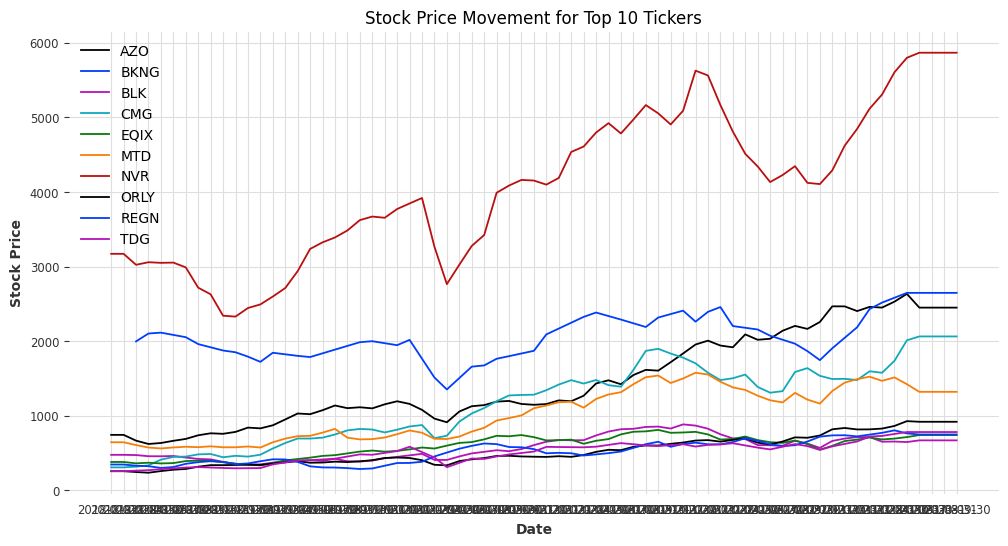

In [72]:
top_tickers = (
    df.groupby('Tickers')
    .agg({'stock_price': 'mean'})
    .sort_values(by='stock_price', ascending=False)
    .head(10)
    .index
)
data_top_tickers = df[df['Tickers'].isin(top_tickers)]
plt.figure(figsize=(12, 6))
for ticker, group in data_top_tickers.groupby('Tickers'):
    plt.plot(group['Date'], group['stock_price'], label=ticker)

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Movement for Top 10 Tickers')
plt.legend()
plt.grid(True)
plt.show()

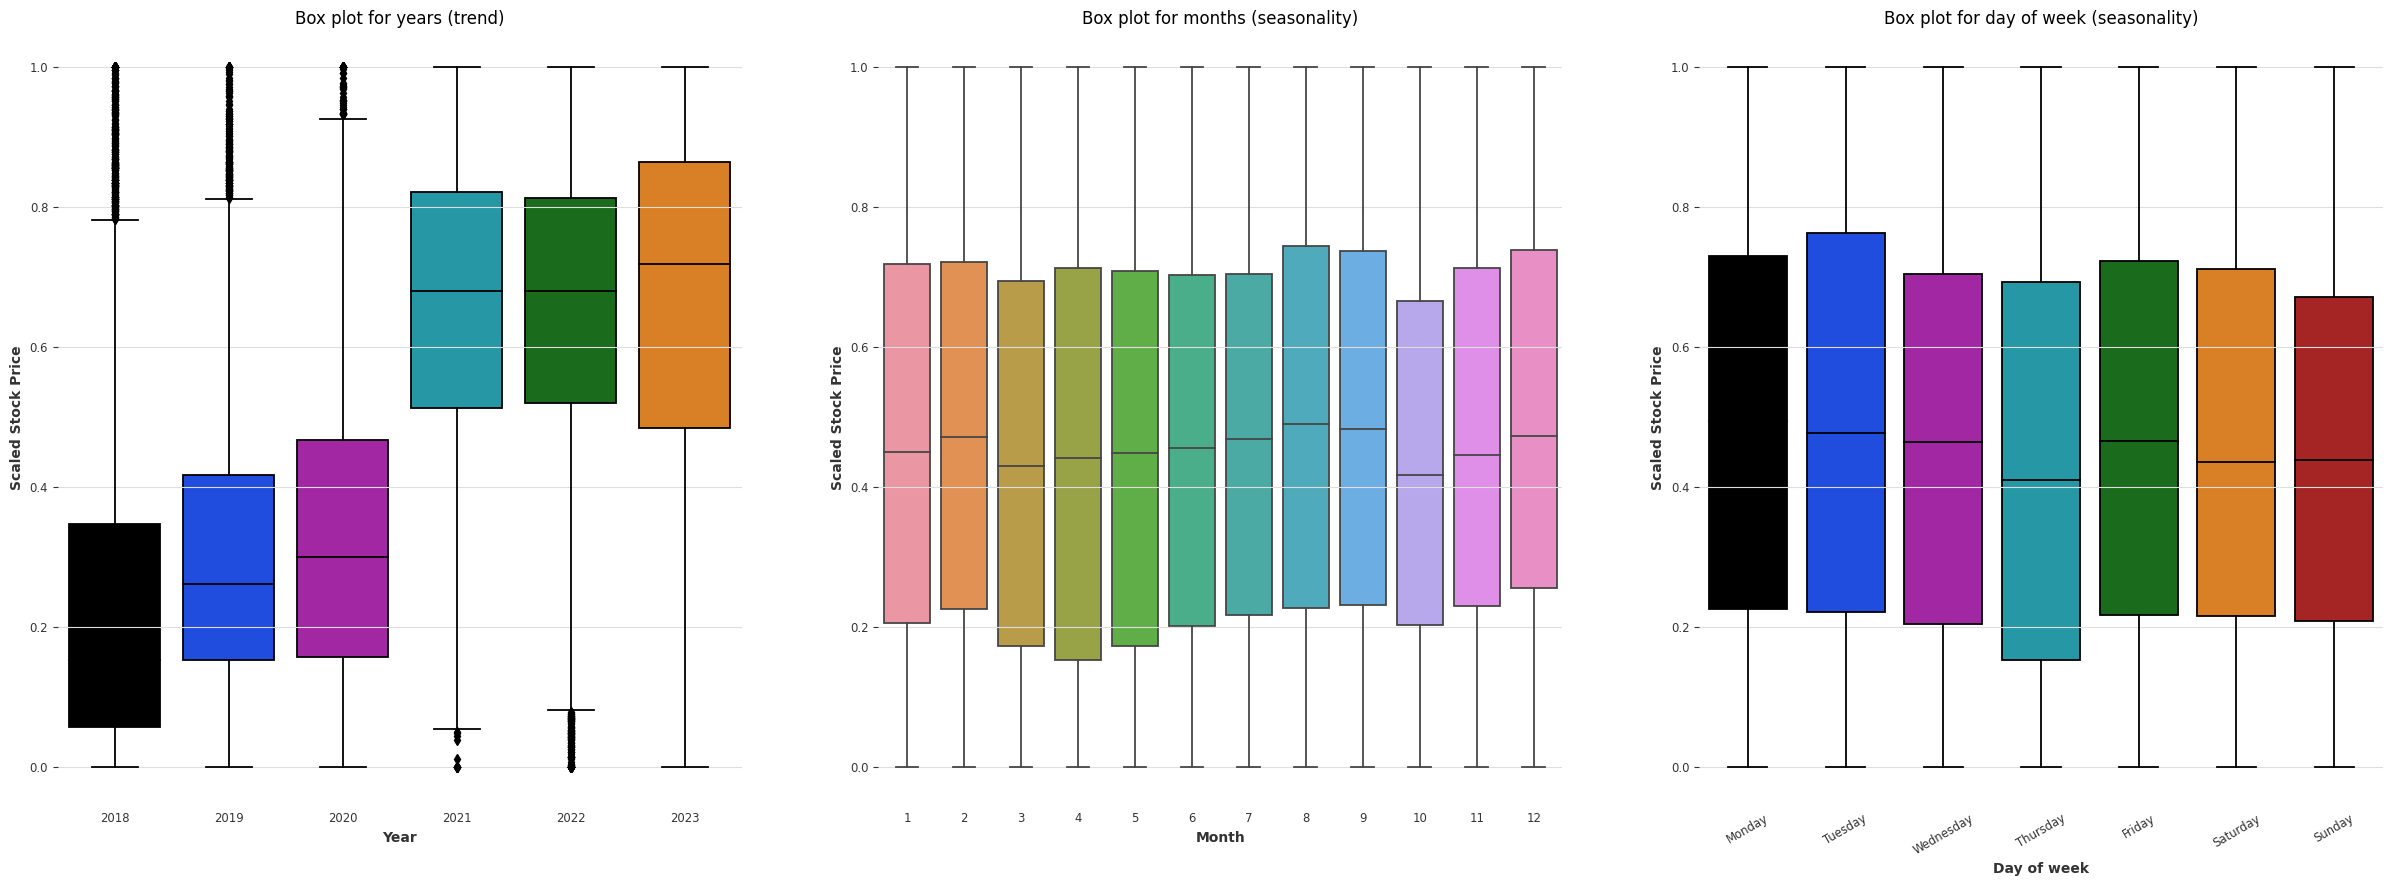

In [75]:
# make copy of df
dataset_scaled_EDA = df.copy()
dataset_scaled_EDA['Date'] = pd.to_datetime(dataset_scaled_EDA['Date'])

# min max value calculation
dataset_scaled_EDA['min_stock_price'] = dataset_scaled_EDA.groupby(['Tickers'])['stock_price'].transform(lambda x: x.min())
dataset_scaled_EDA['max_stock_price'] = dataset_scaled_EDA.groupby(['Tickers'])['stock_price'].transform(lambda x: x.max())
# scale
dataset_scaled_EDA['stock_price_scaled'] = (dataset_scaled_EDA['stock_price'] - dataset_scaled_EDA['min_stock_price'])/(dataset_scaled_EDA['max_stock_price'] - dataset_scaled_EDA['min_stock_price'])
# add info about year, week of year and day of week
dataset_scaled_EDA['year'] = dataset_scaled_EDA['Date'].dt.year
dataset_scaled_EDA['month'] = dataset_scaled_EDA['Date'].dt.month
dataset_scaled_EDA['day_of_week'] = [d.strftime('%A') for d in dataset_scaled_EDA['Date']]
dataset_scaled_EDA['day_of_week'] = pd.Categorical(dataset_scaled_EDA['day_of_week'], 
  categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], 
  ordered=True)

# visualize
fig, ax = plt.subplots(1, 3, figsize=(30, 10))
sns.boxplot(x='year', y='stock_price_scaled', data=dataset_scaled_EDA, ax=ax[0]).set(
    xlabel='Year', 
    ylabel='Scaled Stock Price'
)
ax[0].set_title('Box plot for years (trend)')
sns.boxplot(x='month', y='stock_price_scaled', data=dataset_scaled_EDA, ax=ax[1]).set(
    xlabel='Month', 
    ylabel='Scaled Stock Price'
)
ax[1].set_title('Box plot for months (seasonality)')
sns.boxplot(x='day_of_week', y='stock_price_scaled', data=dataset_scaled_EDA, ax=ax[2]).set(
    xlabel='Day of week', 
    ylabel='Scaled Stock Price'
)
ax[2].set_title('Box plot for day of week (seasonality)')
ax[2].set_xticklabels(ax[2].get_xticklabels(), rotation=30)
plt.show()

**Create TimeSeries object and save in list (required by models in Darts)**

In [60]:
dataset_ts = df.copy()
value_cols = ['Dividend', 'Volume', 'stock_price', 'fed_funds_rate', 'GDP',
              'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
              'operating_ratio', 'inventory_turnover', 'pos_ma', 'neu_ma', 'neg_ma']
dataset_ts = TimeSeries.from_group_dataframe(df=dataset_ts, 
                                             group_cols=['Tickers'],
                                             time_col='Date', 
                                             value_cols=value_cols)

In [64]:
tickers_list = df['Tickers'].unique()

In [67]:
family_TS_dict = {}

for ticker in tickers_list:
  df_family = df.loc[df['ticker_encoded'] == ticker]

  list_of_TS_family = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="Date",
                                group_cols=["ticker_encoded"], 
                                # static_cols=[], 
                                value_cols="stock_price", # target variable
                                fill_missing_dates=True,
                                freq='M')
  for ts in list_of_TS_family:
            ts = ts.astype(np.float32)

  list_of_TS_family = sorted(list_of_TS_family, key=lambda ts: int(ts.static_covariates_values()[0,0]))
  family_TS_dict[ticker] = list_of_TS_family

In [68]:
# Create TimeSeries objects (Darts) 1782

list_of_TS = TimeSeries.from_group_dataframe(
                                df,
                                time_col="Date",
                                group_cols=["ticker_encoded"],  
                                # static_cols=[], 
                                value_cols="stock_price", 
                                fill_missing_dates=True,
                                freq='M')
for ts in list_of_TS:
            ts = ts.astype(np.float32)

list_of_TS = sorted(list_of_TS, key=lambda ts: int(ts.static_covariates_values()[0,0]))

In [ ]:
def flatten(l):
    return [item for sublist in l for item in sublist]

future_covariates_full = []

for ticker in tickers_list:
    future_covariates_full.append(future_covariates_dict[ticker])

future_covariates_full = flatten(future_covariates_full)

**Problems with multiple series:**

1. may miss details, such as anomalies, 
2. perhaps should not process each time series in the same way.
3. typical problems: missing data, data drift, and rare events (black swans).

More series can potentially help us because the model will be able to use more data, and therefore there will be more representative observations for a particular pattern.

**Multivariate vs. Multiple Time Series**

Multivariate: 
- time series are from a single process, are interconnected, correlated, and interact with each other.
- Considers all the stock prices together as a single multivariate time series.
- Uses historical data of all stocks to forecast their future prices simultaneously, taking into account potential interdependencies or correlations between the stock prices.
- produce predictions for all tickers simultaneously as part of the multivariate forecast.
- won't provide individual ticker-specific stock price predictions in isolation from the other tickers.
- provides forecasts for all tickers together, considering their potential interdependencies

Multiple: 
- treat each stock price as an independent time series.
- build separate forecasting models for each stock, considering only its own historical data.
- assumes no interdependencies or correlations between the stock prices and treats them as unrelated.
- individual stock price forecasts and do not consider them to be related
- obtain individual ticker-specific stock price predictions

In [8]:
df1=df.copy()
# Add unique identifier column for each combination of Ticker and Date
df1['Unique_ID'] = df1.groupby(['Tickers', 'Date']).ngroup()

# Define the columns to include in the multivariate time series
value_cols = ['Dividend', 'Volume', 'stock_price', 'fed_funds_rate', 'GDP',
              'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
              'operating_ratio', 'inventory_turnover', 'pos_ma', 'neu_ma', 'neg_ma']

# Pivot the DataFrame to create a multivariate time series
multivariate_series = df.pivot(index='Date', columns='Tickers', values=value_cols)


In [91]:
multivariate_series

Dividend                                                         \
Tickers           A  AAL    AAPL  ABBV   ABT ACGL   ACN ADBE    ADI    ADM   
Date                                                                         
2018-01-31      NaN  0.0  0.0000  0.71  0.28  0.0  0.00  0.0    NaN  0.000   
2018-02-28   0.0000  0.1  0.1575  0.00  0.00  0.0  0.00  0.0  0.000  0.335   
2018-03-31   0.0000  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.384  0.000   
2018-04-30   0.1490  0.0  0.0000  0.96  0.28  0.0  1.33  0.0  0.000  0.000   
2018-05-31   0.0000  0.1  0.1825  0.00  0.00  0.0  0.00  0.0  0.000  0.335   
...             ...  ...     ...   ...   ...  ...   ...  ...    ...    ...   
2023-05-31   0.0000  0.0  0.2400  0.00  0.00  0.0  0.00  0.0  0.000  0.450   
2023-06-30   0.1125  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.430  0.000   
2023-07-31   0.0000  0.0  0.0000  1.48  0.51  0.0  1.12  0.0  0.000  0.000   
2023-08-31   0.0000  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.000  0.000   
2023-09-30   0.0000  0.0  0.0000  0.00  0.00  0.0  0.00  0.0  0.000  0.000   

            ...        neg_ma                                                  \
Tickers     ...          WYNN           XEL       XOM      XRAY           XYL   
Date        ...                                                                 
2018-01-31  ...  7.820502e-03  1.503411e-04  0.077462  0.138637  1.194629e-01   
2018-02-28  ...  1.336066e-05  4.692189e-07  0.187740  0.106750  1.174873e-05   
2018-03-31  ...  8.333690e-07  4.408431e-05  0.079787  0.107042  1.604409e-06   
2018-04-30  ...  6.655623e-05  4.804350e-05  0.099378  0.251238  1.604409e-06   
2018-05-31  ...  3.896794e-05  4.804350e-05  0.073613  0.019688  6.557487e-06   
...         ...           ...           ...       ...       ...           ...   
2023-05-31  ...  1.040856e-07  9.388031e-03  0.329222  0.025153  2.005693e-07   
2023-06-30  ...  1.320341e-01  7.188763e-04  0.000441  0.000006  2.015084e-02   
2023-07-31  ...  8.129173e-03  2.361396e-03  0.000001  0.143079  1.789569e-01   
2023-08-31  ...  3.069017e-02  1.850166e-01  0.004738  0.427556  1.973353e-01   
2023-09-30  ...  4.976273e-01  5.234888e-03  0.499864  0.037201  5.287511e-01   

                                                                      
Tickers          YUM       ZBH          ZBRA          ZION       ZTS  
Date                                                                  
2018-01-31  0.000371  0.096485  8.545747e-07  9.631739e-05  0.008634  
2018-02-28  0.000005  0.036495  1.211151e-03  1.981682e-08  0.000021  
2018-03-31  0.038324  0.013717  2.585805e-04  1.166238e-08  0.000002  
2018-04-30  0.010004  0.112134  2.585805e-04  2.053099e-08  0.000145  
2018-05-31  0.000684  0.028357  1.802918e-05  2.300701e-06  0.000004  
...              ...       ...           ...           ...       ...  
2023-05-31  0.000196  0.004817  8.549383e-01  5.939009e-02  0.000010  
2023-06-30  0.017225  0.002126  5.234137e-07  7.965156e-05  0.058278  
2023-07-31  0.000194  0.008652  5.234137e-07  2.134673e-04  0.007465  
2023-08-31  0.032084  0.000003  1.264666e-02  2.837348e-02  0.333404  
2023-09-30  0.500576  0.000001  5.176677e-06  6.590589e-08  0.000010  

[69 rows x 6748 columns]

In [93]:
# Create a darts TimeSeries object from the pivot table
multivariate_series.index = pd.to_datetime(multivariate_series.index)
multivariate_series = TimeSeries.from_dataframe(multivariate_series,   
                                                freq='M')

In [95]:
scaler = Scaler()
scaled_series = scaler.fit_transform(multivariate_series)

# PyTorch Forecasting

In [ ]:
!pip install lightning
!pip install pytorch_forecasting

In [ ]:
!pip install torch torchvision torchaudio -f https://download.pytorch.org/whl/torch_stable.html


In [ ]:
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

In [8]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [9]:
import torch
import math

# check if PyTorch has access to GPU
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [ ]:
# device = "cuda" if torch.cuda.is_available() else "cpu"

In [16]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [15]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [ ]:
!gsutil ls

In [ ]:
!pip install google-cloud-storage

In [22]:
import pandas as pd
from google.cloud import storage
import os
import io
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'path/to/creds.json'


# def gcp_csv_to_df(bucket_name, source_file_name):
storage_client = storage.Client()
bucket = storage_client.bucket('stockprice_huiye')
blob = bucket.blob('sorted_feature_matrix.csv')
data = blob.download_as_bytes()
test_df = pd.read_csv(io.BytesIO(data))
# print(f'Pulled down file from bucket {bucket_name}, file name: {source_file_name}')
test_df

Unnamed: 0        Date  Dividend        Volume  stock_price  \
0              69  2018-01-31      0.00  5.315047e+06    51.919825   
1             138  2018-01-31      0.00  1.795523e+08    40.275178   
2             207  2018-01-31      0.71  7.794467e+06    87.747239   
3             276  2018-01-31      0.28  7.860137e+06    54.655791   
4             345  2018-01-31      0.00  1.614810e+06    29.889667   
...           ...         ...       ...           ...          ...   
32909       34017  2023-09-30      0.00  2.114983e+06   133.590376   
32910       34086  2023-09-30      0.00  1.614090e+06   135.349948   
32911       34155  2023-09-30      0.00  3.709700e+05   274.414666   
32912       34224  2023-09-30      0.00  5.042810e+06    28.125514   
32913       34293  2023-09-30      0.00  2.192707e+06   168.943788   

       fed_funds_rate          GDP Tickers  debt_to_equity       EPS  \
0                1.41  4500.182000     AAL     -134.253165  0.807713   
1                1.41  4500.182000    AAPL        2.413301  2.970566   
2                1.41  4500.182000    ABBV      -23.651147  1.818001   
3                1.41  4500.182000     ABT        1.333073  0.319962   
4                1.41  4500.182000    ACGL        2.331811  0.564373   
...               ...          ...     ...             ...       ...   
32909            5.08  5105.025000     YUM       -1.693220  1.487544   
32910            5.08  5105.025000     ZBH        0.720673  1.004794   
32911            5.08  5053.623333    ZBRA        1.491979  2.802807   
32912            5.08  5105.025000    ZION       15.511452  1.181283   
32913            5.12  5105.025000     ZTS        1.973622  1.456319   

       return_on_equity  quick ratio  operating_ratio  inventory_turnover  \
0             -0.941772     0.484585         0.476713            1.930838   
1              0.131828     1.098802         0.743752            9.811931   
2             -0.940431     1.083967         0.657965            1.027436   
3              0.018336     1.128287         0.829424            0.837345   
4              0.024308     0.679544         0.278000            0.000000   
...                 ...          ...              ...                 ...   
32909         -0.049550     0.721587         0.427386            0.938914   
32910          0.016942     0.945561         0.834571            0.230908   
32911          0.048128     0.502260         0.854987            0.732639   
32912          0.033125     0.458553         0.388889          -17.000000   
32913          0.145081     1.968344         0.580734            0.224732   

         pos_ma        neu_ma        neg_ma  
0      0.285655  5.198588e-01  1.944860e-01  
1      0.222114  6.974815e-01  8.040471e-02  
2      0.351660  3.990092e-01  2.493303e-01  
3      0.323488  5.800269e-01  9.648529e-02  
4      0.000003  1.541489e-05  9.999820e-01  
...         ...           ...           ...  
32909  0.008204  4.912204e-01  5.005759e-01  
32910  0.499998  5.000007e-01  1.404991e-06  
32911  0.999969  2.603792e-05  5.176677e-06  
32912  1.000000  2.596820e-07  6.590589e-08  
32913  0.000009  9.999810e-01  9.611364e-06  

[32914 rows x 17 columns]

In [5]:
# convert Date column into DateTime and set as integer index in chronological order
df_pytorch = df.copy()
df_pytorch['Date'] = pd.to_datetime(df['Date'])
df_pytorch['Index'] = df_pytorch.groupby('Tickers').cumcount()
df_pytorch

Date  Dividend        Volume  stock_price  fed_funds_rate  \
0     2018-01-31      0.00  5.315047e+06    51.919825            1.41   
1     2018-01-31      0.00  1.795523e+08    40.275178            1.41   
2     2018-01-31      0.71  7.794467e+06    87.747239            1.41   
3     2018-01-31      0.28  7.860137e+06    54.655791            1.41   
4     2018-01-31      0.00  1.614810e+06    29.889667            1.41   
...          ...       ...           ...          ...             ...   
32909 2023-09-30      0.00  2.114983e+06   133.590376            5.08   
32910 2023-09-30      0.00  1.614090e+06   135.349948            5.08   
32911 2023-09-30      0.00  3.709700e+05   274.414666            5.08   
32912 2023-09-30      0.00  5.042810e+06    28.125514            5.08   
32913 2023-09-30      0.00  2.192707e+06   168.943788            5.12   

               GDP Tickers  debt_to_equity       EPS  return_on_equity  \
0      4500.182000     AAL     -134.253165  0.807713         -0.941772   
1      4500.182000    AAPL        2.413301  2.970566          0.131828   
2      4500.182000    ABBV      -23.651147  1.818001         -0.940431   
3      4500.182000     ABT        1.333073  0.319962          0.018336   
4      4500.182000    ACGL        2.331811  0.564373          0.024308   
...            ...     ...             ...       ...               ...   
32909  5105.025000     YUM       -1.693220  1.487544         -0.049550   
32910  5105.025000     ZBH        0.720673  1.004794          0.016942   
32911  5053.623333    ZBRA        1.491979  2.802807          0.048128   
32912  5105.025000    ZION       15.511452  1.181283          0.033125   
32913  5105.025000     ZTS        1.973622  1.456319          0.145081   

       quick ratio  operating_ratio  inventory_turnover    pos_ma  \
0         0.484585         0.476713            1.930838  0.285655   
1         1.098802         0.743752            9.811931  0.222114   
2         1.083967         0.657965            1.027436  0.351660   
3         1.128287         0.829424            0.837345  0.323488   
4         0.679544         0.278000            0.000000  0.000003   
...            ...              ...                 ...       ...   
32909     0.721587         0.427386            0.938914  0.008204   
32910     0.945561         0.834571            0.230908  0.499998   
32911     0.502260         0.854987            0.732639  0.999969   
32912     0.458553         0.388889          -17.000000  1.000000   
32913     1.968344         0.580734            0.224732  0.000009   

             neu_ma        neg_ma  Index  
0      5.198588e-01  1.944860e-01      0  
1      6.974815e-01  8.040471e-02      0  
2      3.990092e-01  2.493303e-01      0  
3      5.800269e-01  9.648529e-02      0  
4      1.541489e-05  9.999820e-01      0  
...             ...           ...    ...  
32909  4.912204e-01  5.005759e-01     68  
32910  5.000007e-01  1.404991e-06     68  
32911  2.603792e-05  5.176677e-06     68  
32912  2.596820e-07  6.590589e-08     68  
32913  9.999810e-01  9.611364e-06     68  

[32914 rows x 17 columns]

In [6]:
prediction_length=6
train_split = df_pytorch["Index"].max() - prediction_length

In [7]:
# Create Multivariate TimeSeries instance
training = TimeSeriesDataSet(
    df_pytorch[lambda x:x.Index <= train_split], 
    group_ids=['Tickers'],
    target='stock_price',
    time_idx='Index',
    max_encoder_length=6,
    max_prediction_length=6,
    static_categoricals=['Tickers'],
    time_varying_known_reals=["Date", "Dividend", 'Volume', 'fed_funds_rate', 'GDP',
                               'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
                               'operating_ratio', 'inventory_turnover'],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["stock_price", 'pos_ma','neu_ma', 'neg_ma'],
    target_normalizer=GroupNormalizer(
        groups=['Tickers'], transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True)

In [8]:
# Create validation set 
# (predict=True) to predict last max_prediction_length points in time for each series
validation = TimeSeriesDataSet.from_dataset(training, df_pytorch, predict=True, stop_randomization=True)

In [9]:
# Create dataloaders
batch_size=64
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

In [10]:
# actuals = torch.cat([y for x, (y, weight) in iter(validation)]).to("mps")
# baseline_predictions = Baseline().predict(validation)
# (actuals - baseline_predictions).abs().mean().item()

In [11]:
# Create baseline model: predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` a

tensor(12.6622, device='mps:0')

**Find optimal learning rate**

In [12]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=160,  
    # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=4,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=160,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 4586.4k


/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/loops/utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.003019951720402016
Restoring states from the checkpoint path at /Users/huiye/code/noorasyikeen/investoinsight/notebooks/.lr_find_3dec4e79-c34d-4e83-9c74-586eadfbaa5b.ckpt
Restored all states from the checkpoint at /Users/huiye/code/noorasyikeen/investoinsight/notebooks/.lr_find_3dec4e79-c34d-4e83-9c74-586eadfbaa5b.ckpt


suggested learning rate: 0.003019951720402016


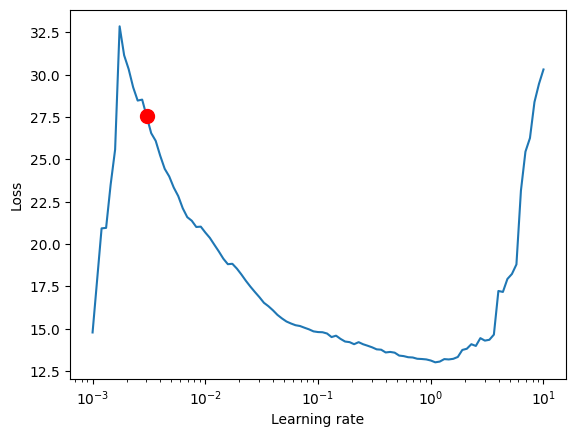

/var/folders/vb/2khx9g0543q0c95vwczxd3p80000gn/T/ipykernel_3456/73107447.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [13]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=0.001,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [16]:
early_stop_callback = EarlyStopping(monitor='val_loss',
                                    min_delta=1e-4,
                                    patience=5,
                                    verbose=True,
                                    mode='min')
checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor='val_loss', mode='min')
# log the learning rate
lr_logger = LearningRateMonitor() 

# logging results to tensorboard
logger = TensorBoardLogger('lightning_logs')

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='cpu',
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=0.1,
    # fast_dev_run=True # for checking that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback],
    enable_checkpointing=True,
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    training, 
    learning_rate=0.0030,
    hidden_size=160, 
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,
    loss=QuantileLoss(),
    optimizer='Ranger',
    log_interval=10, # logging every 10 batches
    reduce_on_plateau_patience=4)

print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 4586.4k


/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [17]:
# fit network
trainer.fit(
    tft, 
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 24.6 K
3  | prescalers                         | ModuleDict                      | 6.1 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 313 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 1.7 M 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.3 M 
7  | static_context_variable_selection  | GatedResidualNetwork            | 103 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 103 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 103 

Sanity Checking: 0it [00:00, ?it/s]

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 13.906


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2.828 >= min_delta = 0.0001. New best score: 11.078


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 1.611 >= min_delta = 0.0001. New best score: 9.468


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.338 >= min_delta = 0.0001. New best score: 9.129


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 9.129. Signaling Trainer to stop.


In [18]:
print(checkpoint_callback.best_model_path)
print(checkpoint_callback.best_model_score)

lightning_logs/lightning_logs/version_20/checkpoints/epoch=4-step=1940.ckpt
tensor(9.1295)


In [293]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(best_model_path)
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

lightning_logs/lightning_logs/version_18/checkpoints/epoch=9-step=3880.ckpt


/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [301]:
# best_model_path = 'lightning_logs/lightning_logs/version_8/checkpoints/epoch=15-step=6208.ckpt'
# best_model_path = 'lightning_logs/lightning_logs/version_11/checkpoints/epoch=7-step=3104.ckpt'
best_model_path = 'lightning_logs/lightning_logs/version_19/checkpoints/epoch=3-step=1552.ckpt'
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [58]:
import torch

model_path = 'lightning_logs/lightning_logs/version_11/best-model.pkt'
# Save the model to the specified file path
torch.save(best_tft.state_dict(), model_path)


In [ ]:
# Tensorboard
%load ext tensorboard
%tensorboard --logdir "lightning_logs/lightning_logs/version_12"

In [ ]:
# import pickle

# # Hyperparameter tuning, overloads RAM on Google Colab
# from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# study = optimize_hyperparameters(
#     train_dataloader,
#     val_dataloader,
#     model_path='optuna_test',
#     n_trials=200,
#     max_epochs=50,
#     gradient_clip_val_range=(0.01, 1.0),
#     hidden_size_range=(8, 240),
#     hidden_continuous_size_range=(8, 240),
#     attention_head_size_range=(1, 4),
#     learning_rate_range=(0.001, 0.1),
#     dropout_range=(0.1, 0.3),
#     trainer_kwargs=dict(accelerator='cpu',limit_train_batches=30),
#     reduce_on_plateau_patience=4,
#     use_learning_rate_finder=False # use Optuna to find ideal learning rate or use in-built learning rate finder
# )

# # save results
# with open("test_study.pkl", "wb") as fout:
#     pickle.dump(study, fout)

# # show best hyperparameters
# print(study.best_trial_params)

In [302]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
predictions.output

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


tensor([[142.9838, 145.0299, 147.7037, 150.2642, 152.5141, 154.2744],
        [ 15.1582,  15.2521,  15.5295,  15.9470,  16.4621,  17.0433],
        [151.8627, 155.2724, 154.1946, 155.0163, 155.6959, 156.0300],
        ...,
        [294.8728, 293.7100, 297.6092, 302.9980, 309.8675, 317.4179],
        [ 39.1978,  39.0257,  38.7605,  38.8133,  39.1787,  39.8497],
        [168.5974, 169.2964, 171.4070, 174.6333, 176.4248, 178.3924]])

In [83]:
predictions.output.shape

torch.Size([482, 6])

In [78]:
predictions.y

(tensor([[135.8041, 129.4614, 119.7503, 119.7503, 119.7503, 119.7503],
         [ 14.5255,  13.9833,  13.9833,  13.9833,  13.9833,  13.9833],
         [162.5061, 170.5693, 180.4047, 180.4047, 180.4047, 180.4047],
         ...,
         [295.8787, 274.1280, 274.4147, 274.4147, 274.4147, 274.4147],
         [ 28.6716,  25.7913,  28.1255,  28.1255,  28.1255,  28.1255],
         [168.9421, 176.2359, 168.9438, 168.9438, 168.9438, 168.9438]]),
 None)

In [79]:
MAE()(predictions.output, predictions.y)

tensor(17.7253)

In [80]:
SMAPE()(predictions.output, predictions.y)

tensor(0.0940)

In [81]:
RMSE()(predictions.output, predictions.y)

tensor(52.2729)

In [303]:
# max encoder length increased from 6 to 12
MAE()(predictions.output, predictions.y)

tensor(15.9769)

In [304]:
SMAPE()(predictions.output, predictions.y)

tensor(0.0922)

In [305]:
RMSE()(predictions.output, predictions.y)

tensor(41.0879)

In [281]:
# raw predictions: dictionary of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, 
                                   mode="raw", 
                                   return_x=True, 
                                   trainer_kwargs=dict(accelerator="cpu"))

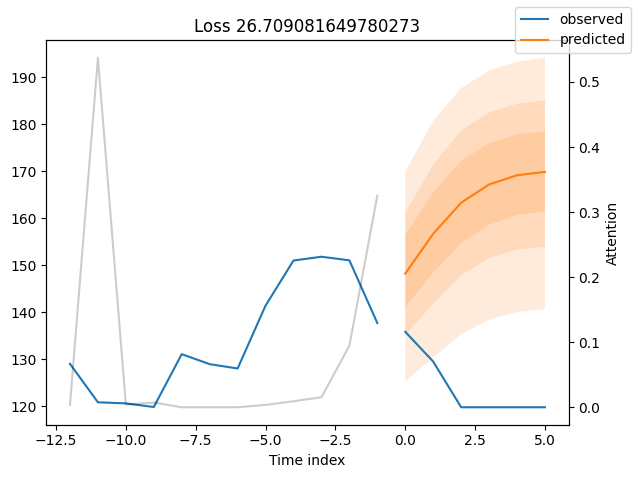

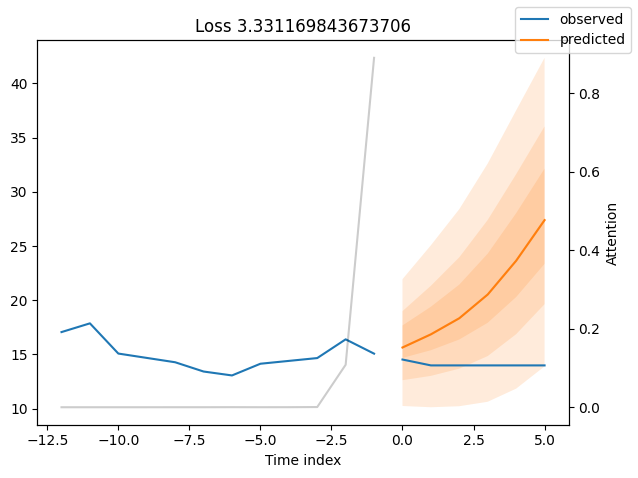

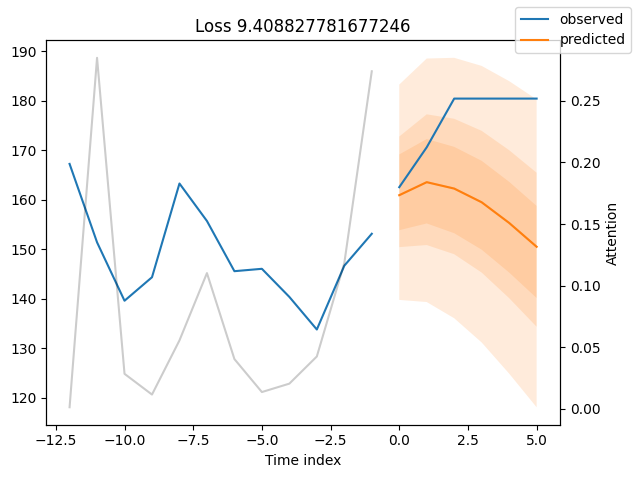

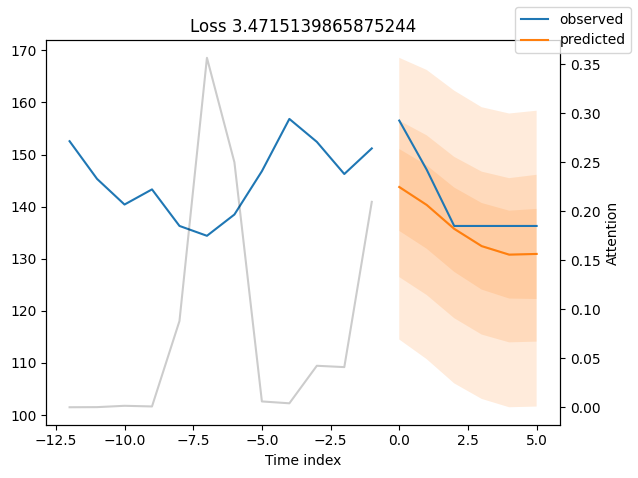

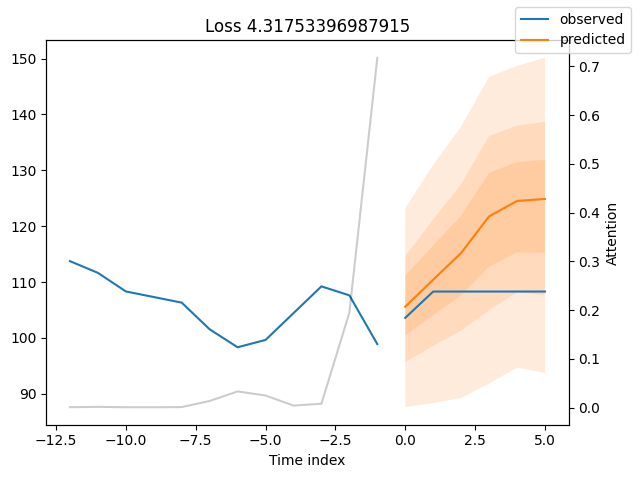

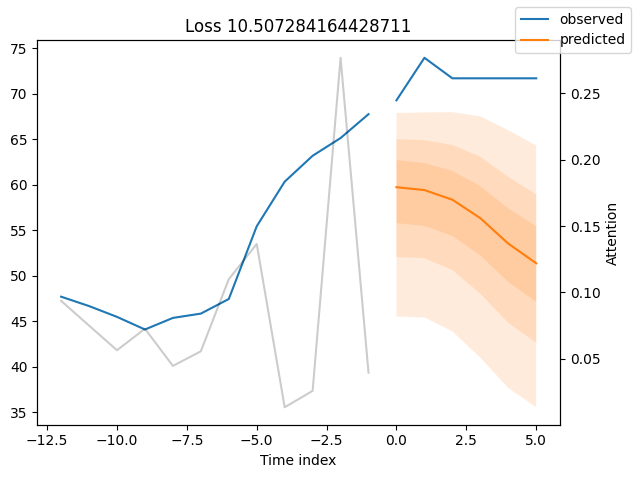

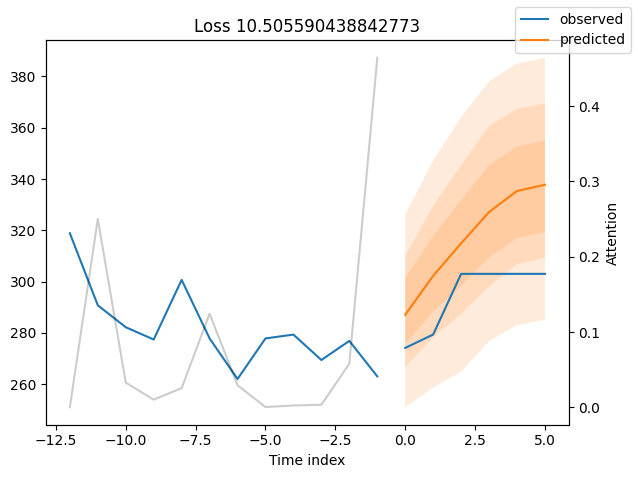

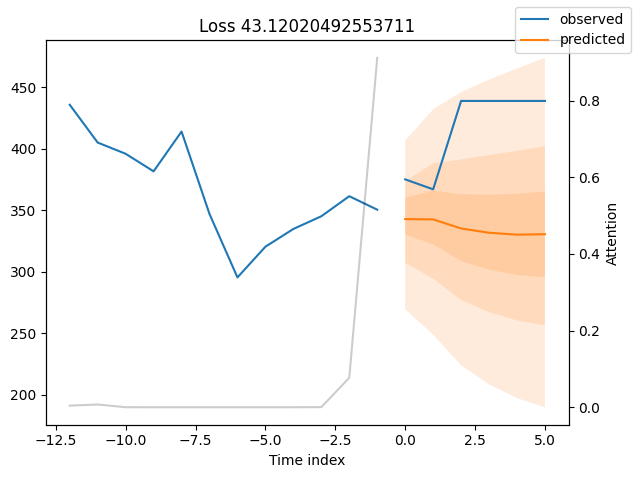

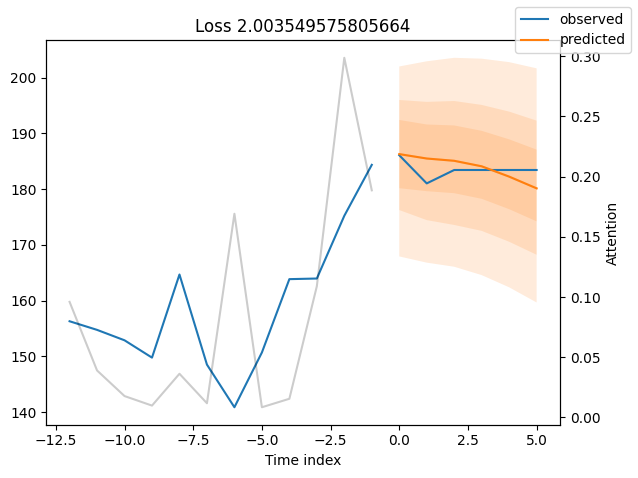

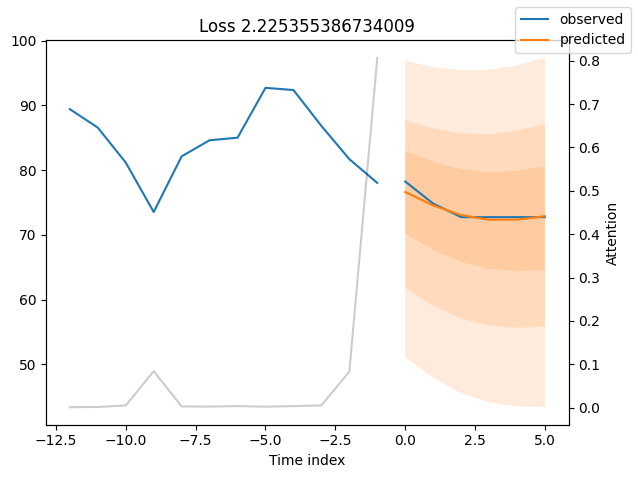

In [282]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)

**Dark blue line: 50% or median quantile value prediction**

**Lighter shades: various quantile prediction bands around the median, denote the range of prediction**

**Grey line: amount of attention TFT pays to each points in time when making predictions (how impactful each timesteps are when the model outputs its prediction.**

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'stock_price_center': <Figure size 1000x500 with 2 Axes>,
 'stock_price_scale': <Figure size 1000x500 with 2 Axes>,
 'Date': <Figure size 1000x500 with 2 Axes>,
 'Dividend': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'fed_funds_rate': <Figure size 1000x500 with 2 Axes>,
 'GDP': <Figure size 1000x500 with 2 Axes>,
 'debt_to_equity': <Figure size 1000x500 with 2 Axes>,
 'EPS': <Figure size 1000x500 with 2 Axes>,
 'return_on_equity': <Figure size 1000x500 with 2 Axes>,
 'quick ratio': <Figure size 1000x500 with 2 Axes>,
 'operating_ratio': <Figure size 1000x500 with 2 Axes>,
 'inventory_turnover': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'stock_price': <Figure size 1000x500 with 2 Axes>,
 'pos_ma': <Figure size 1000x500 with 2 Axes>,
 'neu_ma': <Figure size 1000x500 with 2 Axes>,
 'neg_ma': <Figure size 1000x500 with 2 Axes>,
 'Tickers': <F

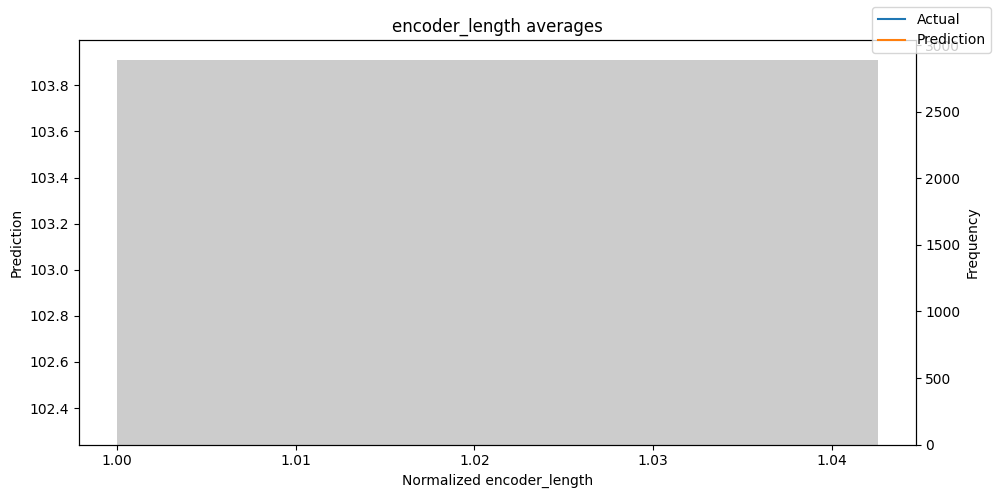

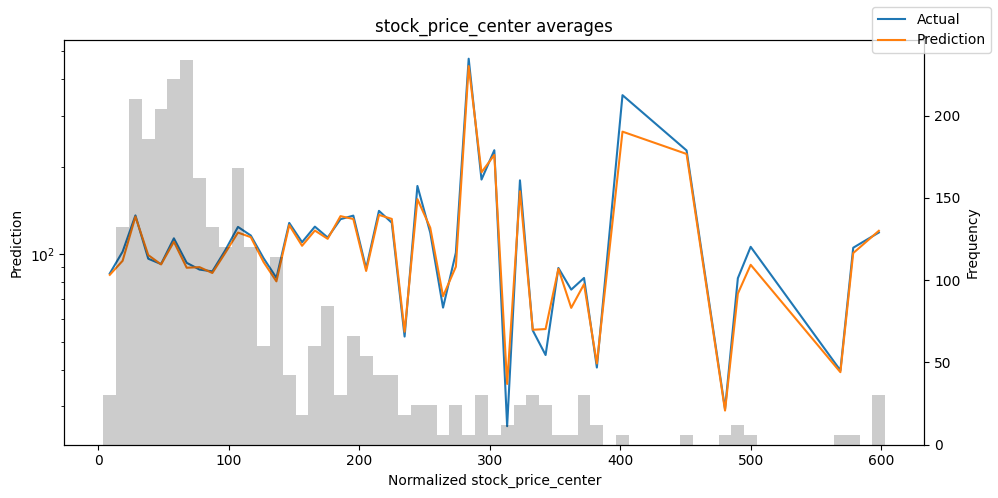

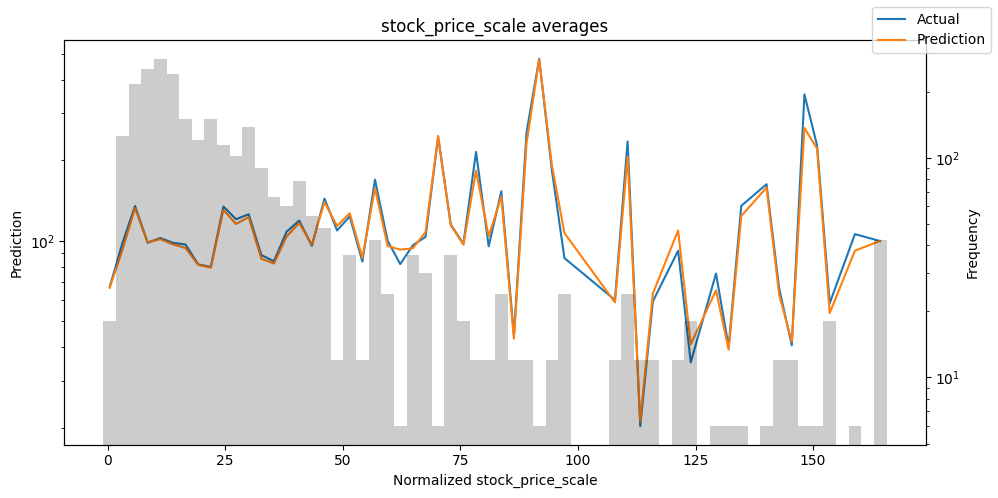

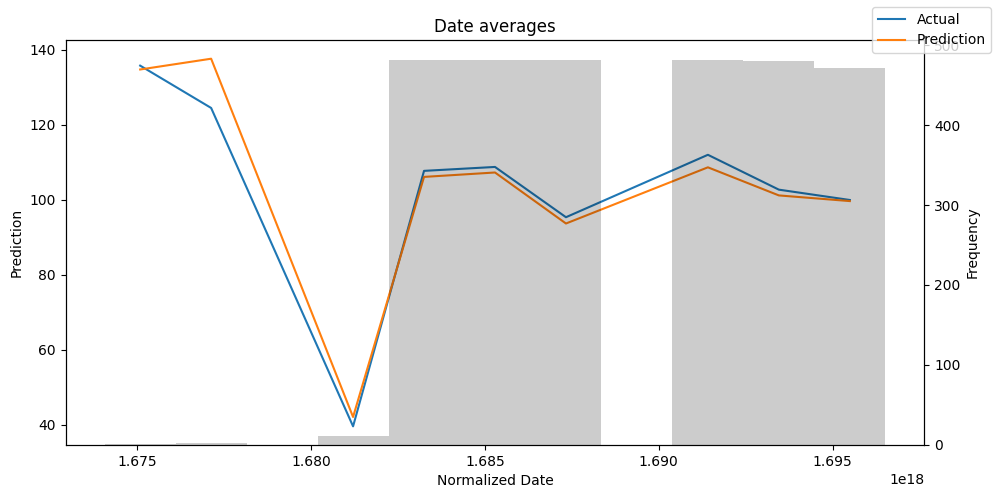

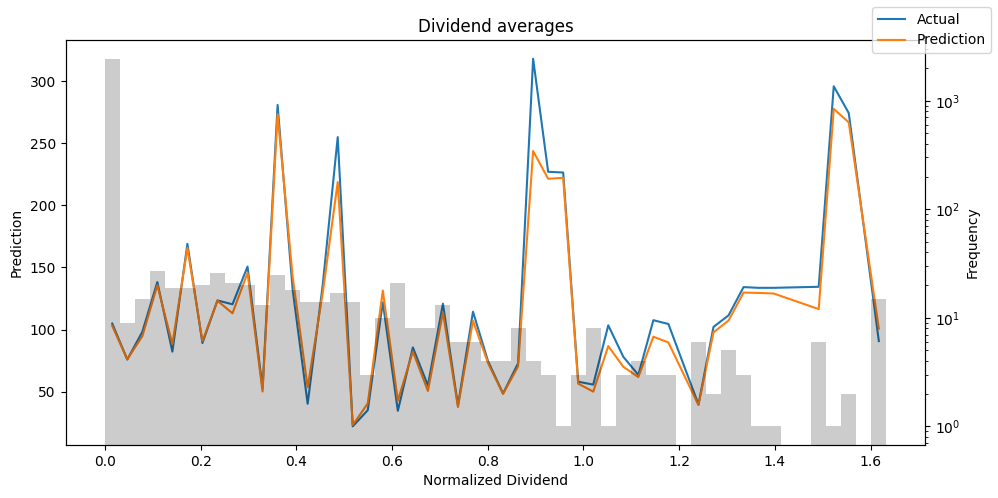

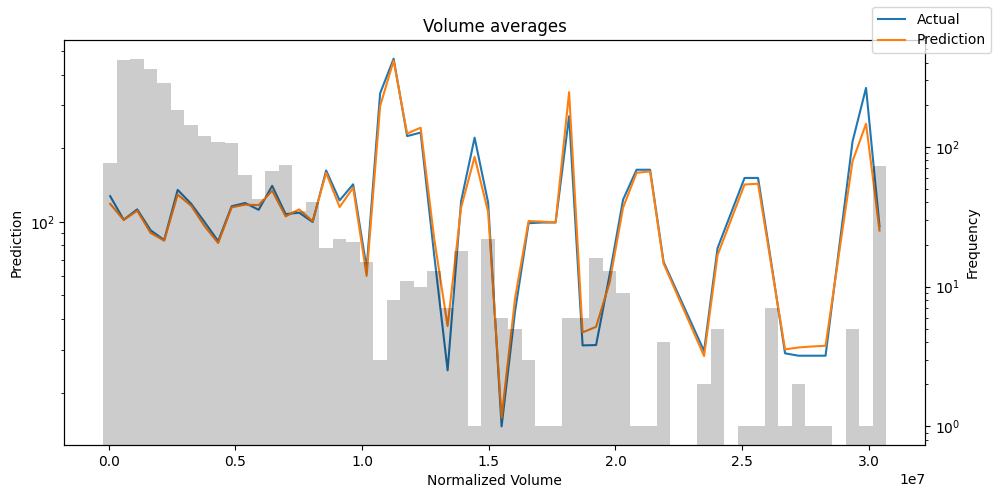

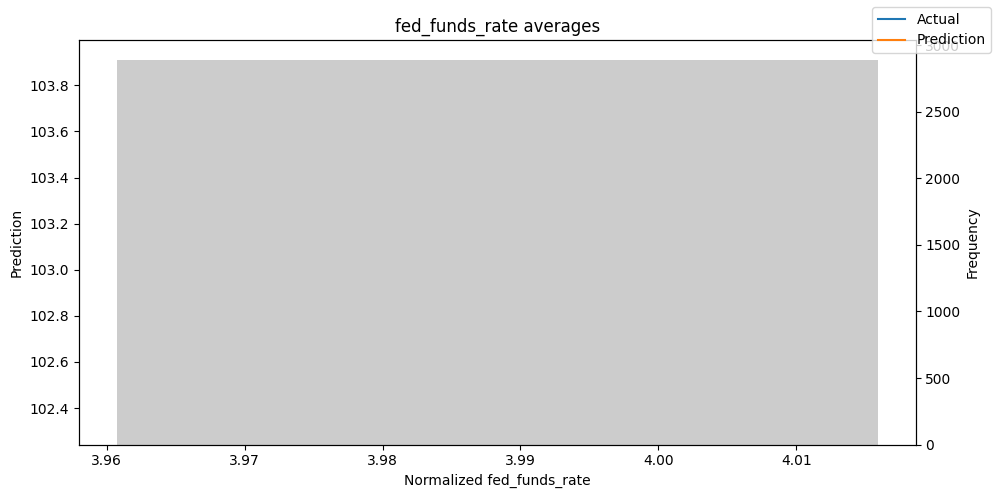

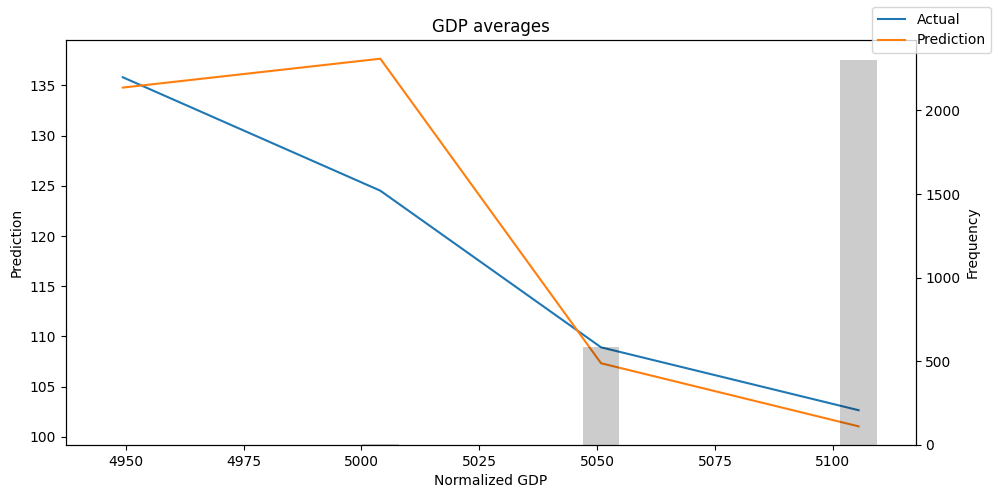

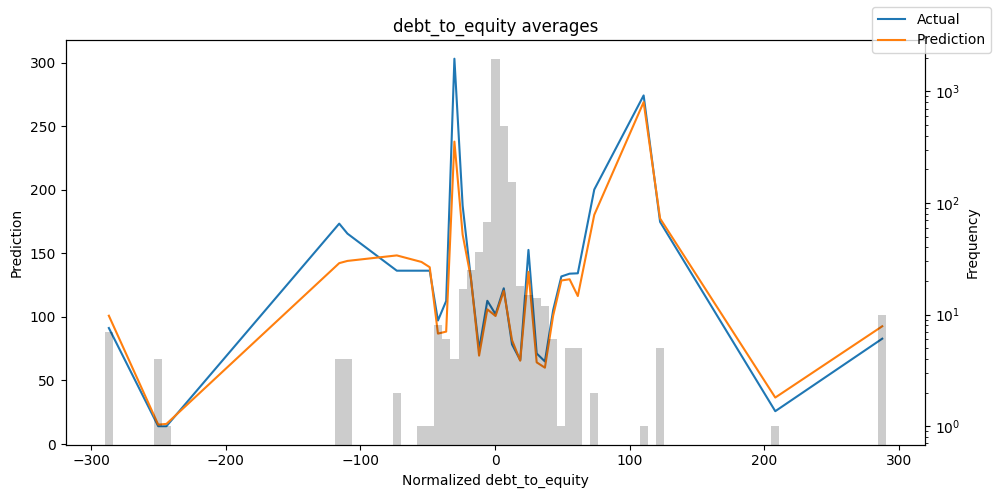

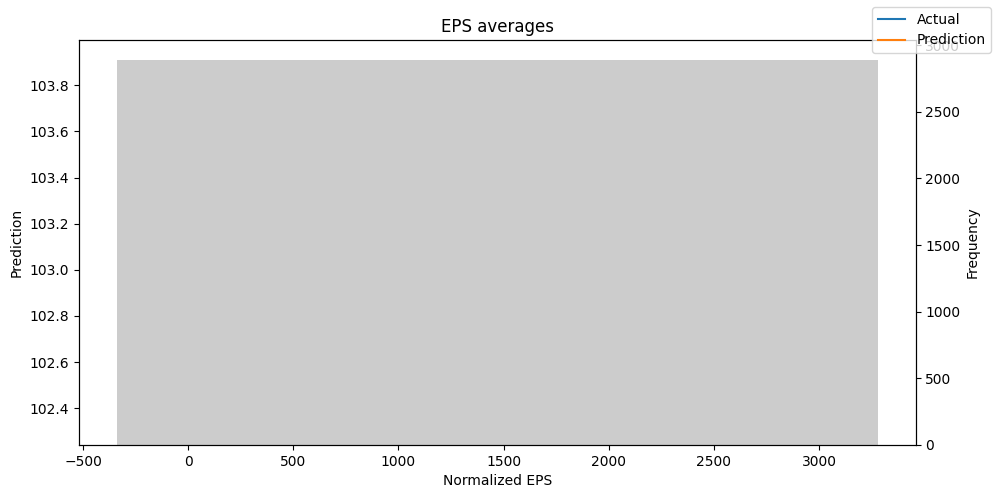

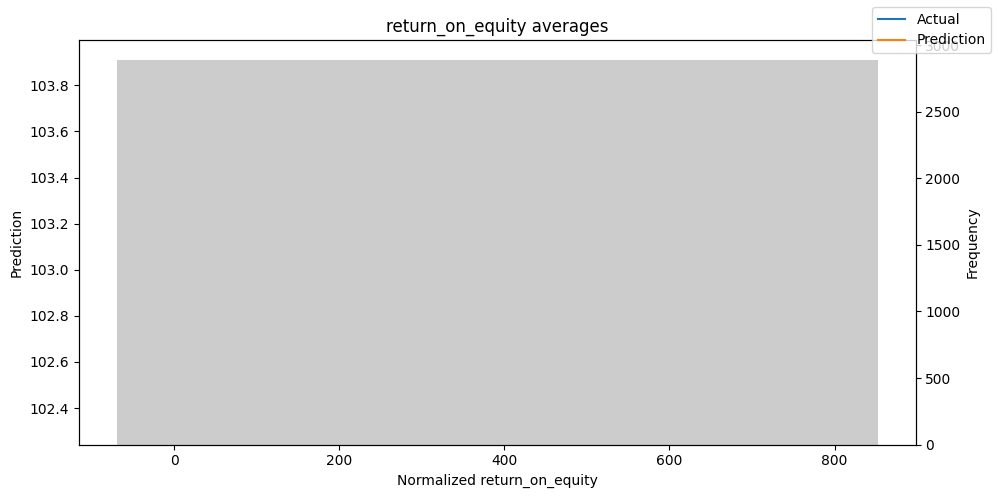

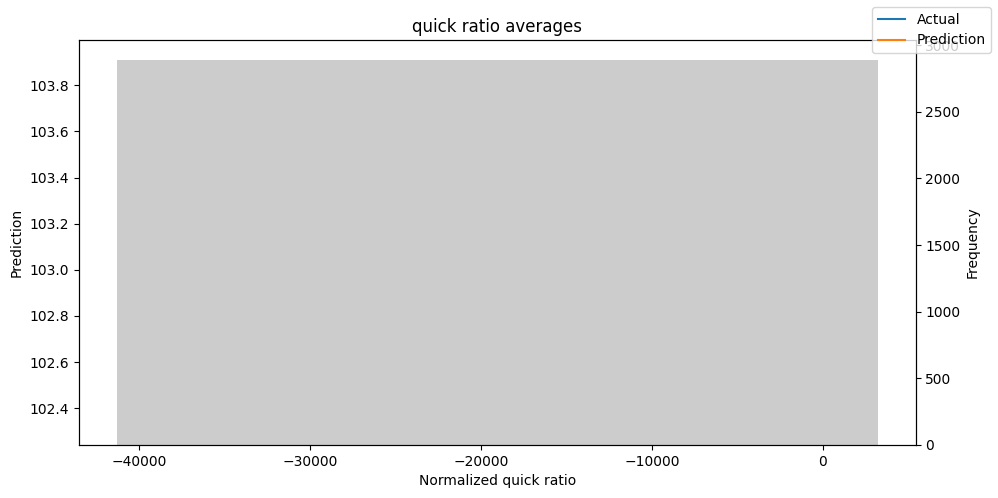

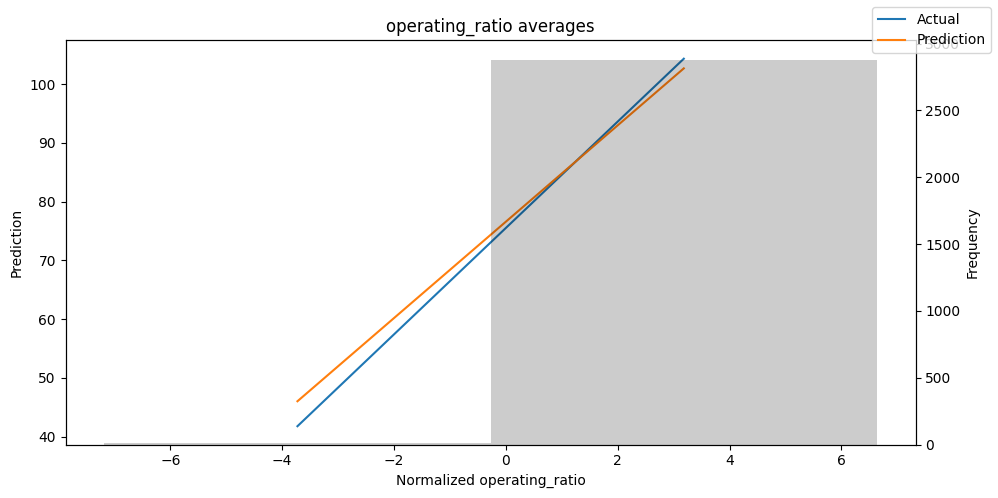

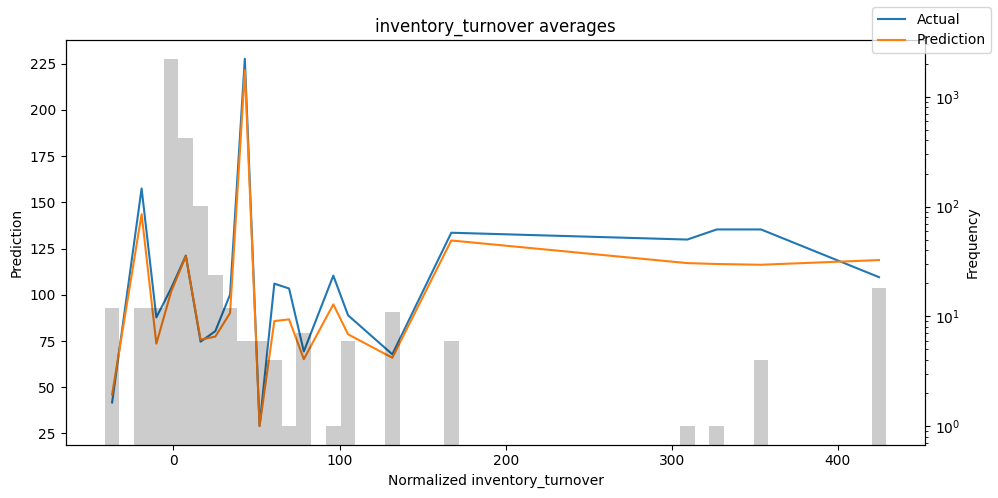

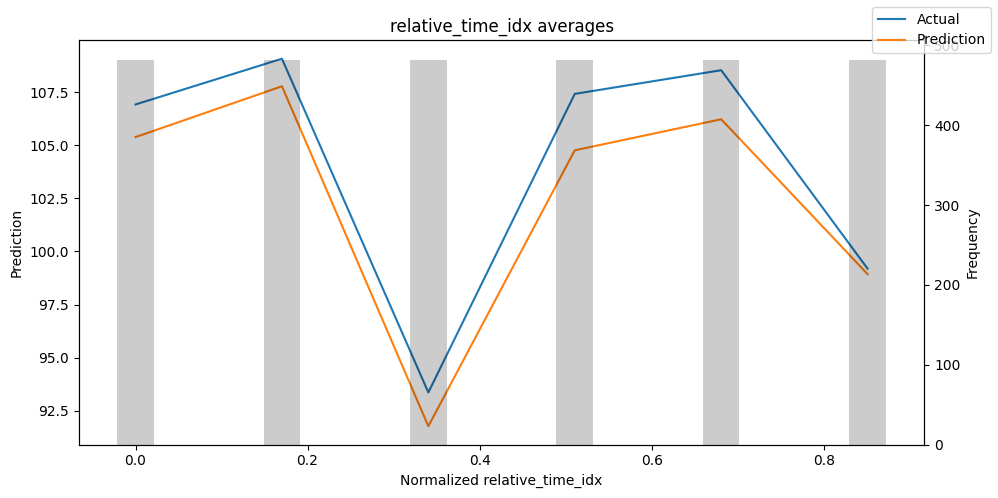

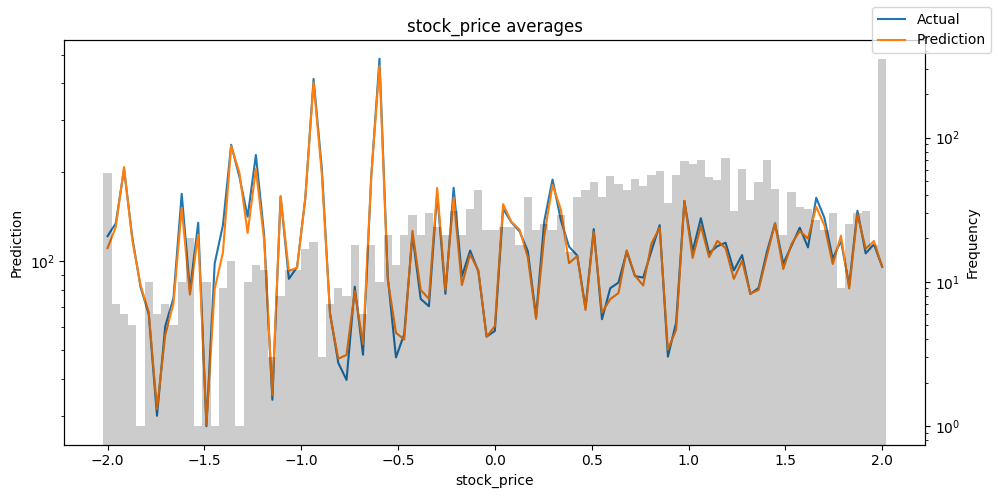

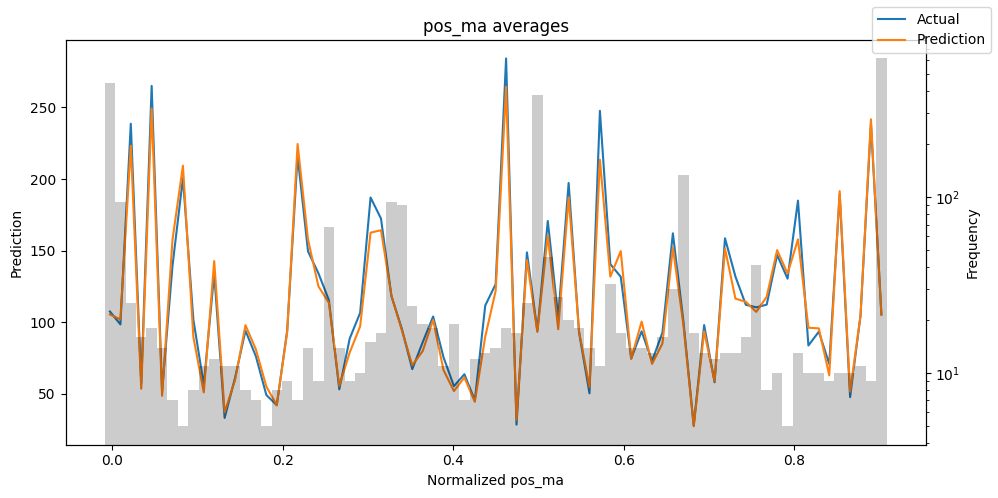

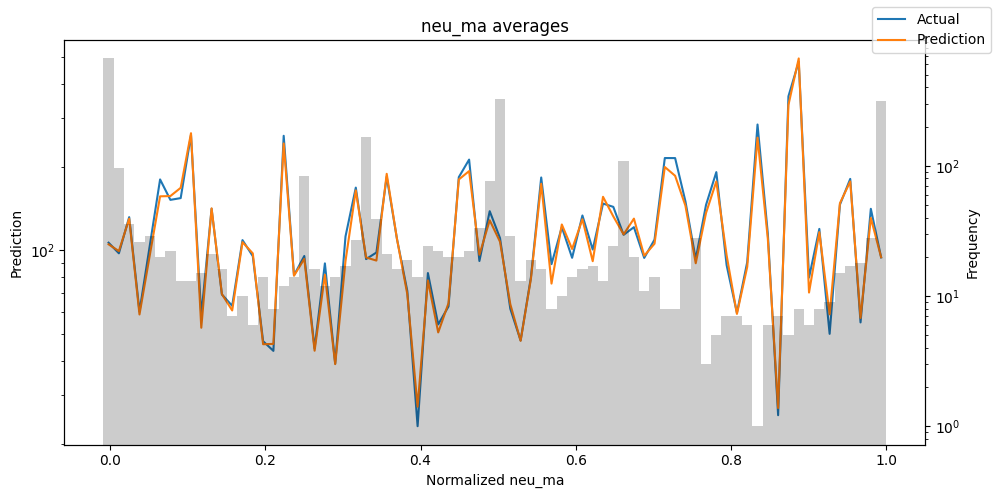

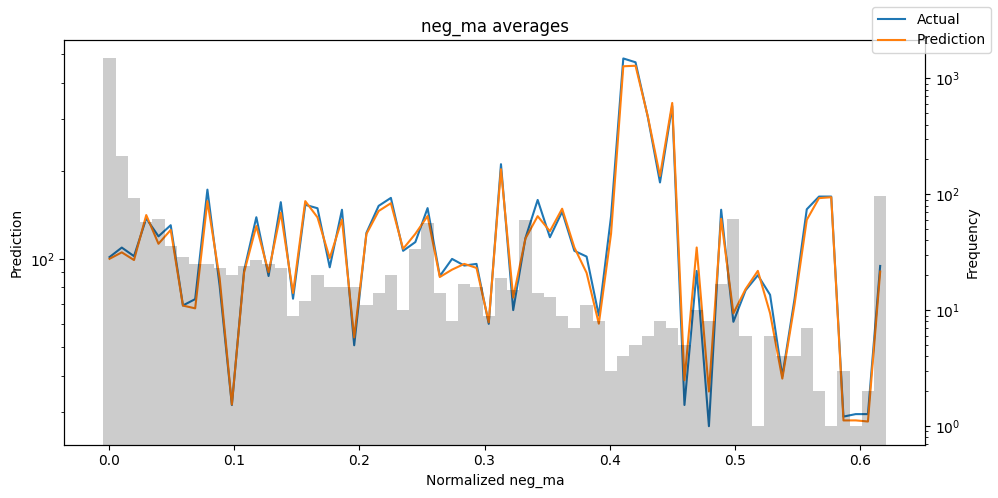

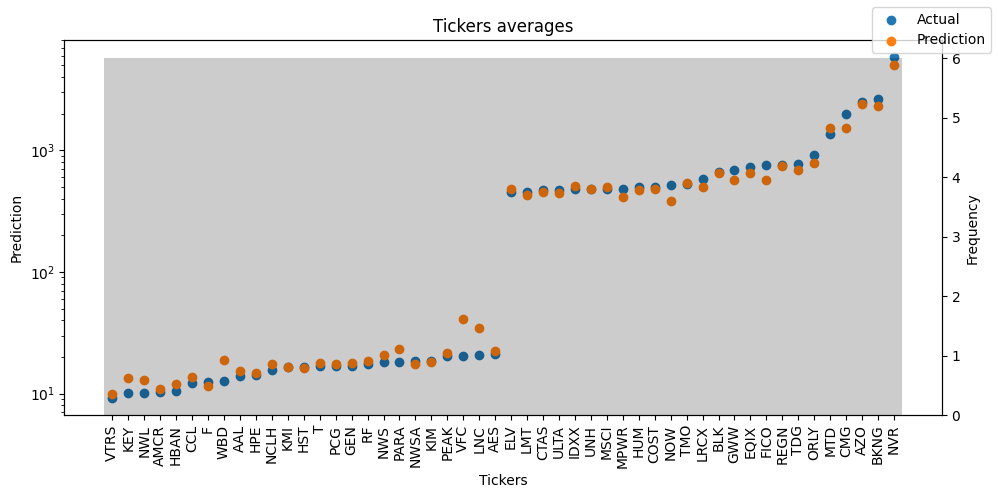

In [94]:
predictions = best_tft.predict(val_dataloader, return_x=True, trainer_kwargs=dict(accelerator="cpu"))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [95]:
# Predict on selected data
best_tft.predict(
    training.filter(lambda x: (x.Tickers == "AAPL") & (x.time_idx_first_prediction == 45)),
    mode="quantiles",
    trainer_kwargs=dict(accelerator='cpu')
)

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


tensor([[[134.7798, 139.1871, 141.3893, 149.5792, 155.8504, 162.7989, 170.8346],
         [137.9582, 144.5817, 149.6602, 160.2453, 166.4798, 175.2322, 186.2477],
         [139.5616, 146.5625, 153.2393, 164.0358, 172.2996, 182.2424, 193.6968],
         [139.0616, 146.2582, 153.0235, 162.3793, 172.2556, 180.9669, 190.4638],
         [135.1050, 141.2288, 147.1654, 156.0916, 165.3040, 173.9742, 181.5139],
         [137.2286, 145.0153, 151.0235, 160.8188, 170.2925, 178.9744, 187.8230]]])

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


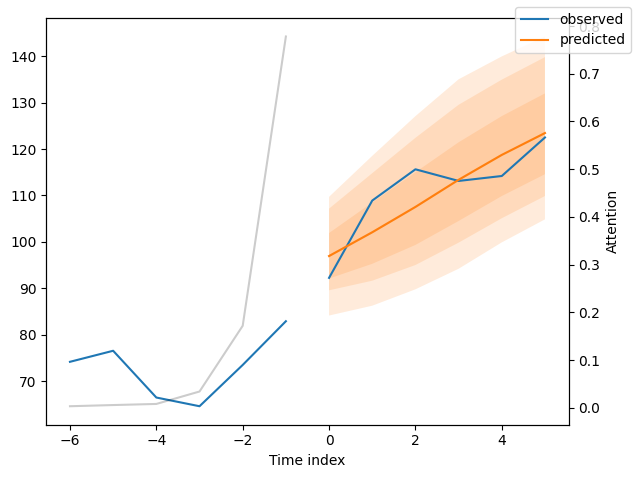

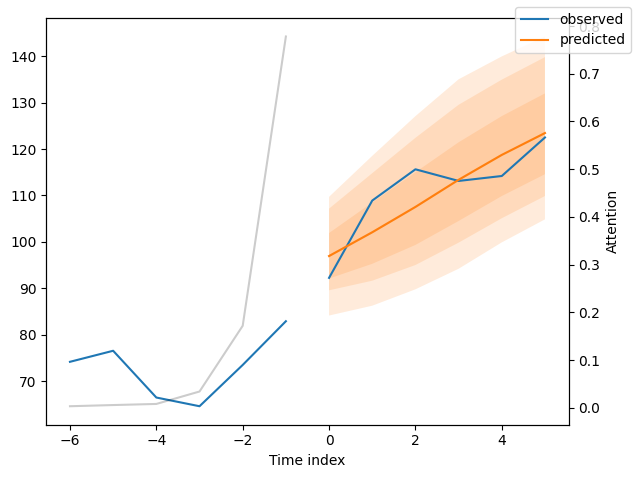

In [96]:
# Plot prediction
raw_prediction = best_tft.predict(
    training.filter(lambda x: (x.Tickers == "AAPL") & (x.time_idx_first_prediction == 30)),
    mode="raw",
    return_x=True,
    trainer_kwargs=dict(accelerator='cpu')
)
best_tft.plot_prediction(raw_prediction.x, raw_prediction.output, idx=0)

In [146]:
df_pytorch.Date.max()

Timestamp('2023-09-30 00:00:00')

In [181]:
# select last 6 months from data (max_encoder_length is 6)
max_prediction_length = 12
encoder_data = df_pytorch[lambda x: x.Index > x.Index.max() - 12]

# select last known data point and create decoder data from it by repeating it and incrementing the month
last_data = df_pytorch[lambda x: x.Index == x.Index.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["Index"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month
decoder_data["Index"] += encoder_data["Index"].max() + 1 - decoder_data["Index"].min()

# adjust additional time feature(s)
# decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [182]:
new_prediction_data

Date  Dividend        Volume  stock_price  fed_funds_rate  \
0     2022-10-31      0.00  3.851403e+07    13.057000            3.08   
1     2022-10-31      0.00  9.459152e+07   145.540596            3.08   
2     2022-10-31      1.41  5.781940e+06   138.489687            3.08   
3     2022-10-31      0.47  6.940340e+06    98.321206            3.08   
4     2022-10-31      0.00  5.481613e+06    47.441667            3.08   
...          ...       ...           ...          ...             ...   
10825 2023-09-30      0.00  2.114983e+06   133.590376            5.08   
10826 2023-09-30      0.00  1.614090e+06   135.349948            5.08   
10827 2023-09-30      0.00  3.709700e+05   274.414666            5.08   
10828 2023-09-30      0.00  5.042810e+06    28.125514            5.08   
10829 2023-09-30      0.00  2.192707e+06   168.943788            5.12   

               GDP Tickers  debt_to_equity       EPS  return_on_equity  \
0      5157.178000     AAL      -10.173963  0.907008         -0.081955   
1      5157.178000    AAPL        5.656863  1.496776          0.451949   
2      5157.178000    ABBV        7.558852  1.952005          0.210613   
3      5157.178000     ABT        1.036728  0.743526          0.036127   
4      5157.178000    ACGL        2.853001  0.812091          0.024490   
...            ...     ...             ...       ...               ...   
10825  5105.025000     YUM       -1.693220  1.487544         -0.049550   
10826  5105.025000     ZBH        0.720673  1.004794          0.016942   
10827  5053.623333    ZBRA        1.491979  2.802807          0.048128   
10828  5105.025000    ZION       15.511452  1.181283          0.033125   
10829  5105.025000     ZTS        1.973622  1.456319          0.145081   

       quick ratio  operating_ratio  inventory_turnover    pos_ma  \
0         0.661929         0.558064            2.120882  0.000001   
1         0.859910         0.717944           10.227621  0.500000   
2         0.834734         0.828718            1.432430  0.000059   
3         1.356569         0.859545            0.785160  0.023467   
4         0.720869         0.354042            0.000000  0.726968   
...            ...              ...                 ...       ...   
10825     0.721587         0.427386            0.938914  0.008204   
10826     0.945561         0.834571            0.230908  0.499998   
10827     0.502260         0.854987            0.732639  0.999969   
10828     0.458553         0.388889          -17.000000  1.000000   
10829     1.968344         0.580734            0.224732  0.000009   

             neu_ma        neg_ma  Index       date  
0      4.999936e-01  5.000054e-01     57        NaT  
1      4.999601e-01  3.986342e-05     57        NaT  
2      4.999519e-01  4.999893e-01     57        NaT  
3      9.718559e-01  4.676753e-03     57        NaT  
4      2.337701e-02  2.496553e-01     57        NaT  
...             ...           ...    ...        ...  
10825  4.912204e-01  5.005759e-01     69 2024-09-01  
10826  5.000007e-01  1.404991e-06     69 2024-09-01  
10827  2.603792e-05  5.176677e-06     69 2024-09-01  
10828  2.596820e-07  6.590589e-08     69 2024-09-01  
10829  9.999810e-01  9.611364e-06     69 2024-09-01  

[10830 rows x 18 columns]

In [183]:
new_prediction_data.dtypes

Date                  datetime64[ns]
Dividend                     float64
Volume                       float64
stock_price                  float64
fed_funds_rate               float64
GDP                          float64
Tickers                       object
debt_to_equity               float64
EPS                          float64
return_on_equity             float64
quick ratio                  float64
operating_ratio              float64
inventory_turnover           float64
pos_ma                       float64
neu_ma                       float64
neg_ma                       float64
Index                          int64
date                  datetime64[ns]
dtype: object

In [184]:
encoder_data.dtypes

Date                  datetime64[ns]
Dividend                     float64
Volume                       float64
stock_price                  float64
fed_funds_rate               float64
GDP                          float64
Tickers                       object
debt_to_equity               float64
EPS                          float64
return_on_equity             float64
quick ratio                  float64
operating_ratio              float64
inventory_turnover           float64
pos_ma                       float64
neu_ma                       float64
neg_ma                       float64
Index                          int64
dtype: object

In [124]:
new_raw_predictions = best_tft.predict(encoder_data,
                                       mode="raw",
                                       return_x=True,
                                       trainer_kwargs=dict(accelerator='cpu'))

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 38 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__Tickers': 'A'}, {'__group_id__Tickers': 'ADI'}, {'__group_id__Tickers': 'AMCR'}, {'__group_id__Tickers': 'AXON'}, {'__group_id__Tickers': 'BBWI'}, {'__group_id__Tickers': 'BBY'}, {'__group_id__Tickers': 'BKNG'}, {'__group_id__Tickers': 'CI'}, {'__group_id__Tickers': 'CME'}, {'__group_id__Tickers': 'CPT'}]
  warnings.warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

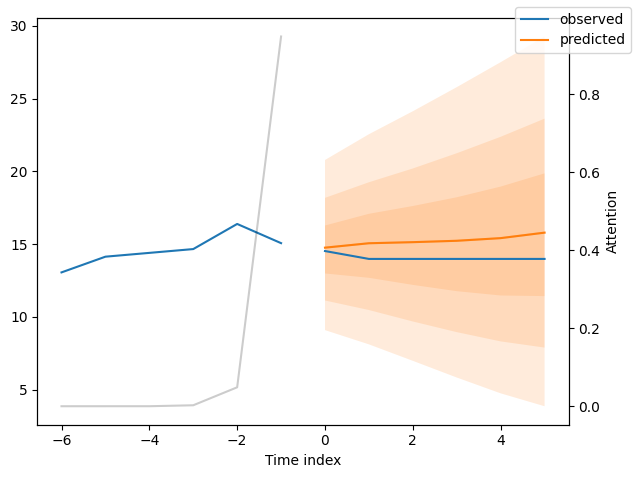

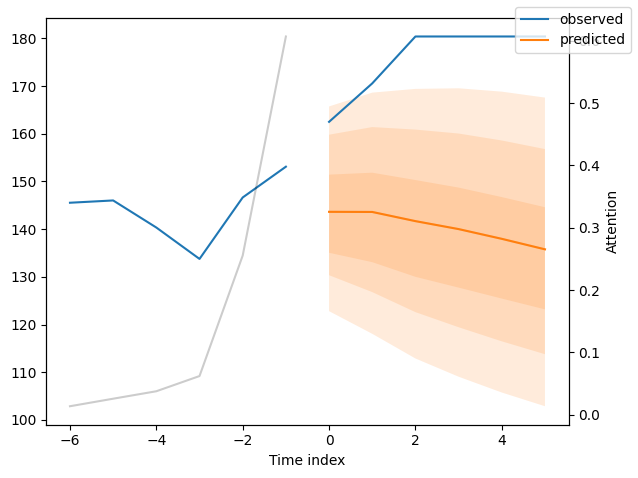

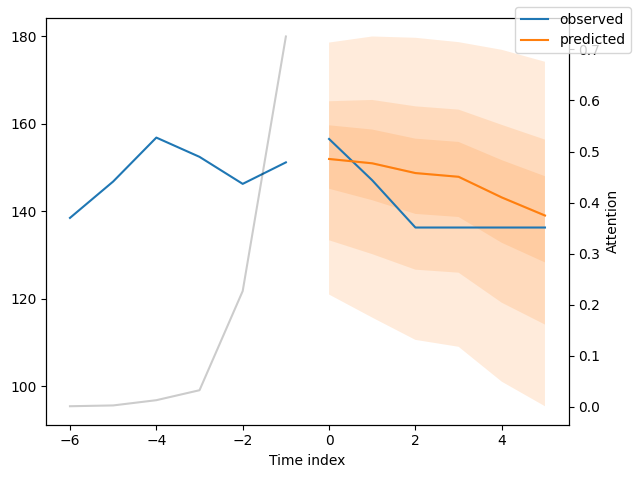

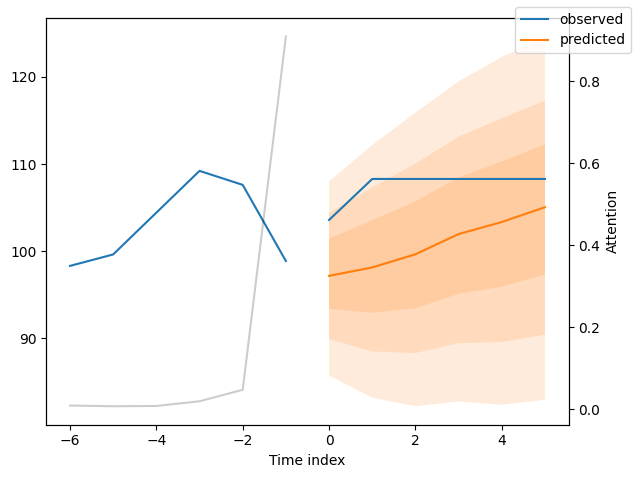

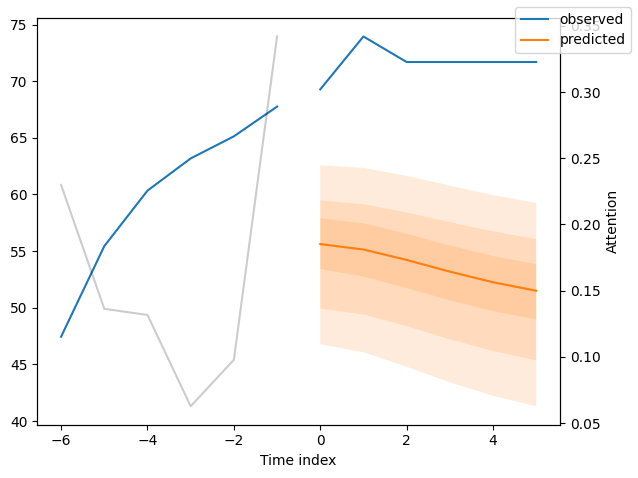

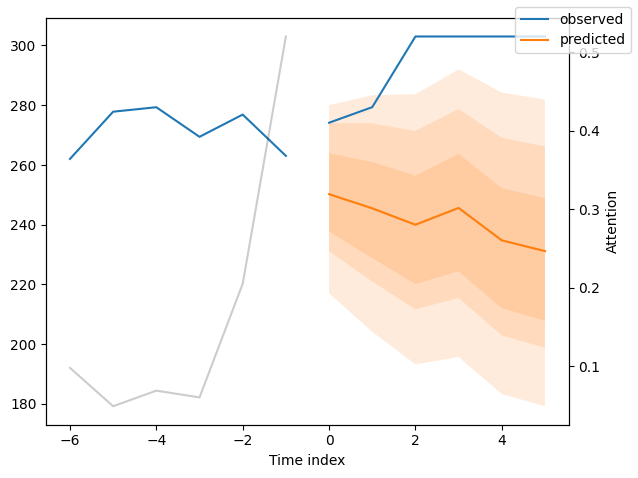

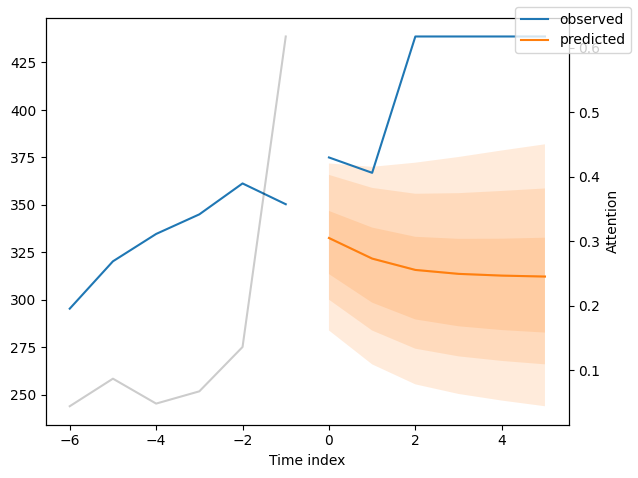

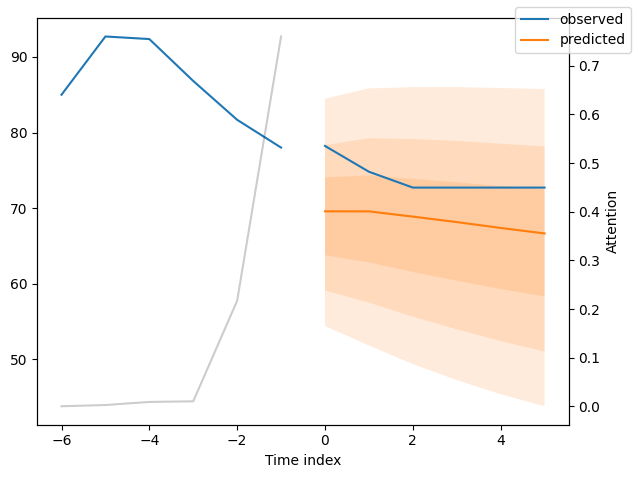

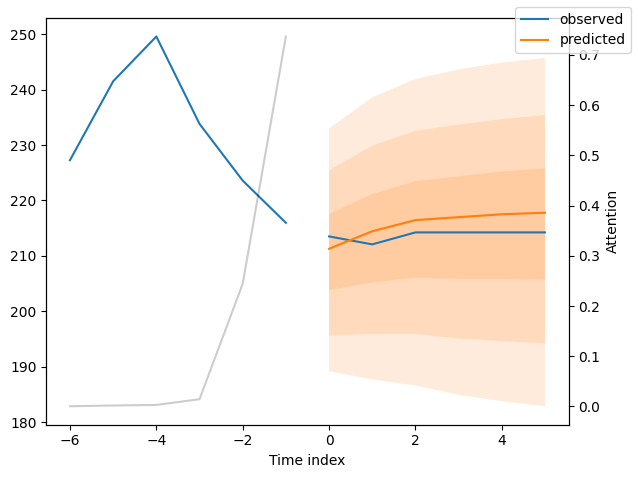

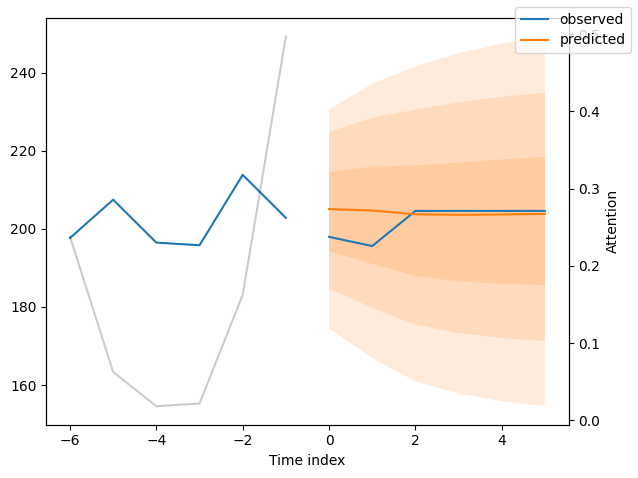

In [125]:
# Plot 10 examples
for idx in range(10):
    best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output,
                             idx=idx, show_future_observed=True)

In [147]:
new_raw_predictions.output

Output(prediction=tensor([[[122.8077, 130.3476, 135.0516, 143.6367, 151.4331, 159.8098, 165.7344],
         [118.0556, 126.8023, 133.0808, 143.6071, 151.8411, 161.4100, 168.6320],
         [112.8831, 122.6002, 130.0108, 141.6845, 150.3009, 160.8824, 169.4157],
         [109.0576, 119.4329, 127.7474, 140.0148, 148.7165, 160.0560, 169.5423],
         [105.7467, 116.4755, 125.4467, 137.9719, 146.7254, 158.5971, 168.8372],
         [102.8674, 113.7791, 123.1837, 135.7712, 144.5974, 156.7936, 167.5923]]]), encoder_attention=tensor([[[[2.8764e-04, 9.1828e-04, 3.4697e-03, 4.9136e-02, 1.8570e-01,
           7.6049e-01],
          [8.5654e-06, 1.5350e-04, 1.1570e-03, 1.9505e-02, 2.0360e-01,
           7.7557e-01],
          [2.3590e-02, 5.0936e-02, 7.8817e-02, 8.1738e-02, 3.4013e-01,
           4.2479e-01],
          [1.6238e-02, 4.9992e-02, 6.6586e-02, 9.7649e-02, 2.9474e-01,
           4.7479e-01]],

         [[7.2545e-04, 1.7584e-03, 5.2555e-03, 5.3969e-02, 1.9247e-01,
           7.4582e-01]

In [123]:
encoder_data

Date  Dividend        Volume  stock_price  fed_funds_rate  \
27145 2022-10-31      0.00  3.851403e+07    13.057000            3.08   
27146 2022-10-31      0.00  9.459152e+07   145.540596            3.08   
27147 2022-10-31      1.41  5.781940e+06   138.489687            3.08   
27148 2022-10-31      0.47  6.940340e+06    98.321206            3.08   
27149 2022-10-31      0.00  5.481613e+06    47.441667            3.08   
...          ...       ...           ...          ...             ...   
32909 2023-09-30      0.00  2.114983e+06   133.590376            5.08   
32910 2023-09-30      0.00  1.614090e+06   135.349948            5.08   
32911 2023-09-30      0.00  3.709700e+05   274.414666            5.08   
32912 2023-09-30      0.00  5.042810e+06    28.125514            5.08   
32913 2023-09-30      0.00  2.192707e+06   168.943788            5.12   

               GDP Tickers  debt_to_equity       EPS  return_on_equity  \
27145  5157.178000     AAL      -10.173963  0.907008         -0.081955   
27146  5157.178000    AAPL        5.656863  1.496776          0.451949   
27147  5157.178000    ABBV        7.558852  1.952005          0.210613   
27148  5157.178000     ABT        1.036728  0.743526          0.036127   
27149  5157.178000    ACGL        2.853001  0.812091          0.024490   
...            ...     ...             ...       ...               ...   
32909  5105.025000     YUM       -1.693220  1.487544         -0.049550   
32910  5105.025000     ZBH        0.720673  1.004794          0.016942   
32911  5053.623333    ZBRA        1.491979  2.802807          0.048128   
32912  5105.025000    ZION       15.511452  1.181283          0.033125   
32913  5105.025000     ZTS        1.973622  1.456319          0.145081   

       quick ratio  operating_ratio  inventory_turnover    pos_ma  \
27145     0.661929         0.558064            2.120882  0.000001   
27146     0.859910         0.717944           10.227621  0.500000   
27147     0.834734         0.828718            1.432430  0.000059   
27148     1.356569         0.859545            0.785160  0.023467   
27149     0.720869         0.354042            0.000000  0.726968   
...            ...              ...                 ...       ...   
32909     0.721587         0.427386            0.938914  0.008204   
32910     0.945561         0.834571            0.230908  0.499998   
32911     0.502260         0.854987            0.732639  0.999969   
32912     0.458553         0.388889          -17.000000  1.000000   
32913     1.968344         0.580734            0.224732  0.000009   

             neu_ma        neg_ma  Index  
27145  4.999936e-01  5.000054e-01     57  
27146  4.999601e-01  3.986342e-05     57  
27147  4.999519e-01  4.999893e-01     57  
27148  9.718559e-01  4.676753e-03     57  
27149  2.337701e-02  2.496553e-01     57  
...             ...           ...    ...  
32909  4.912204e-01  5.005759e-01     68  
32910  5.000007e-01  1.404991e-06     68  
32911  2.603792e-05  5.176677e-06     68  
32912  2.596820e-07  6.590589e-08     68  
32913  9.999810e-01  9.611364e-06     68  

[5598 rows x 17 columns]

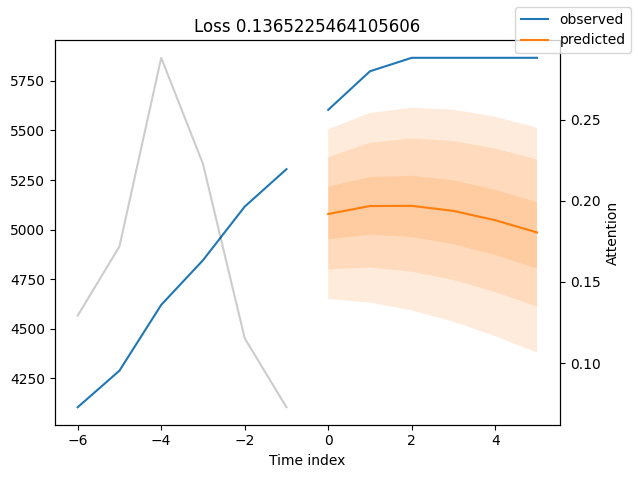

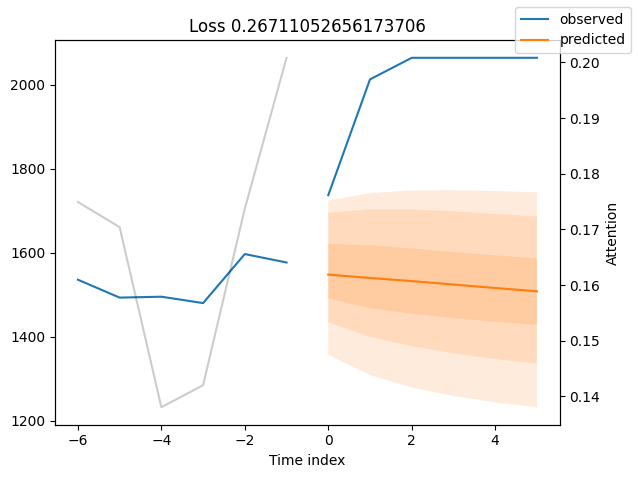

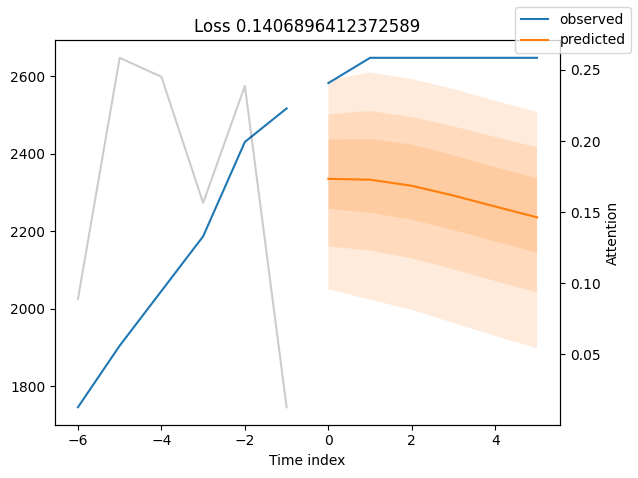

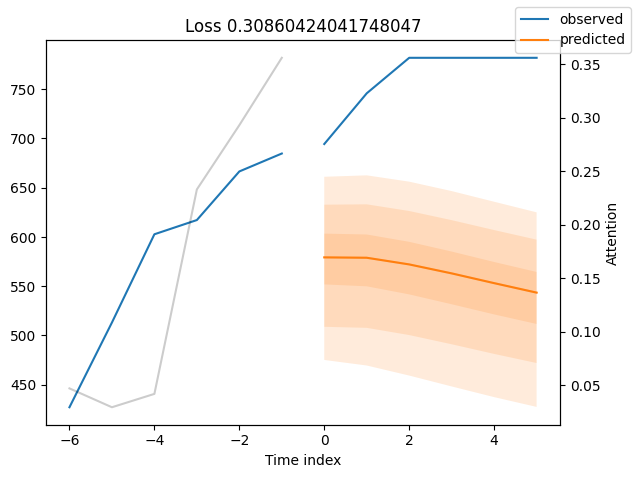

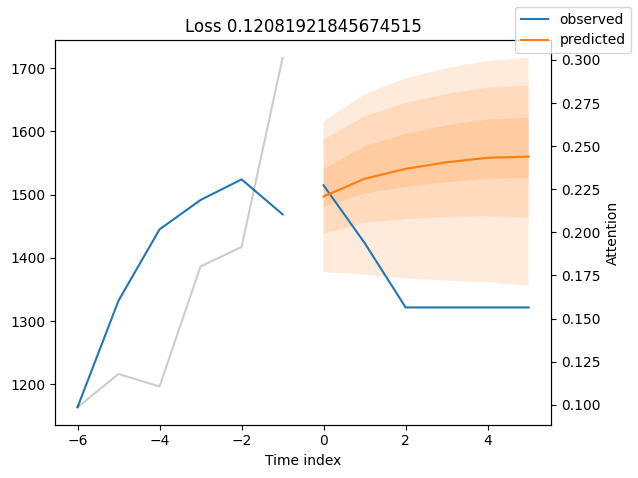

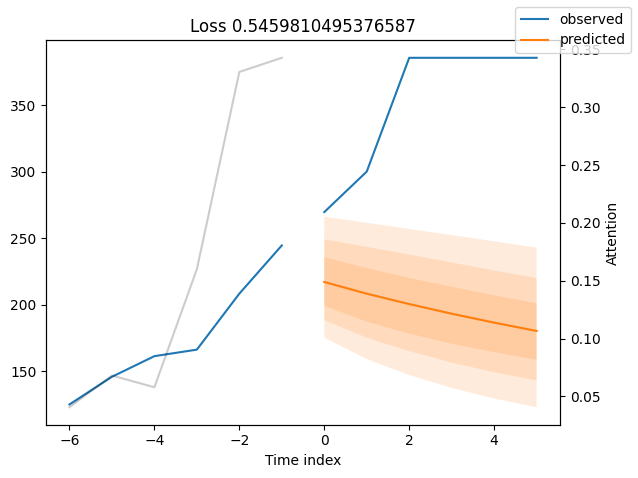

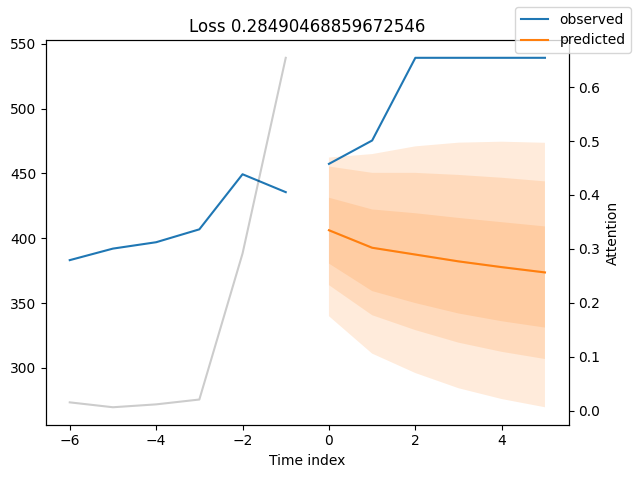

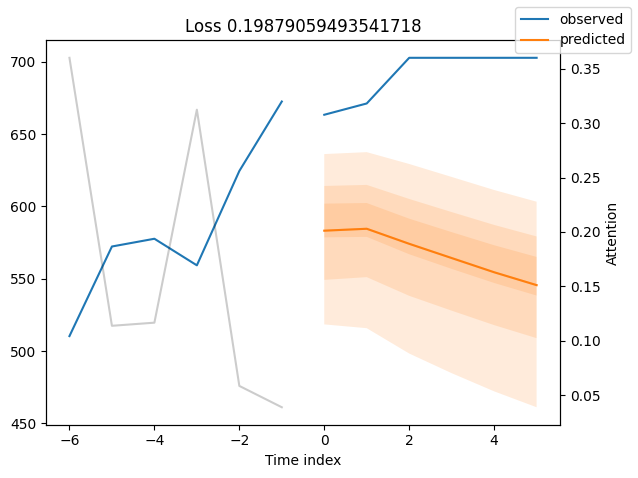

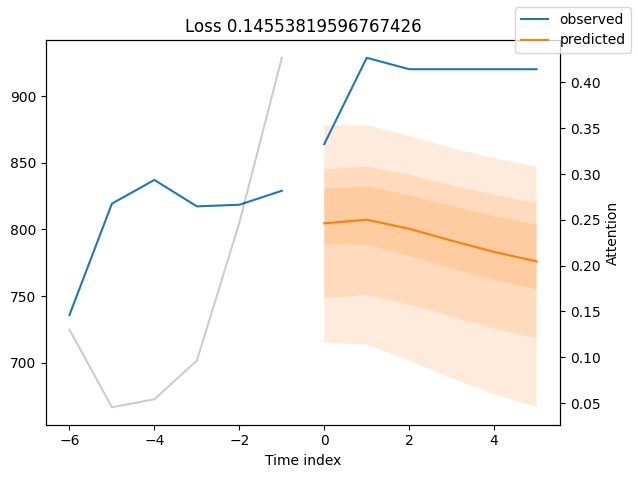

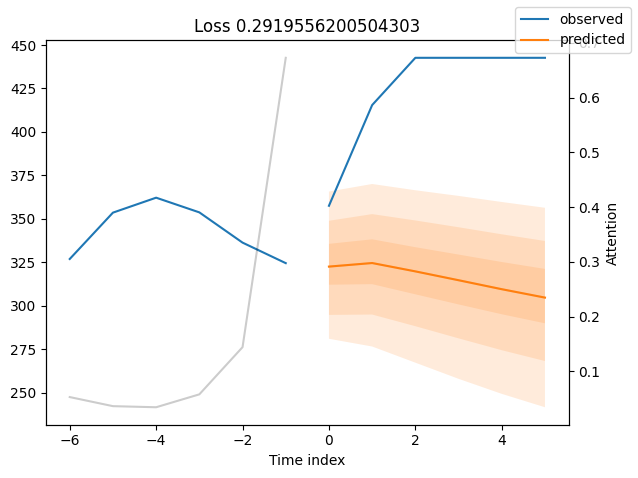

In [129]:
# Worst performers
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator='cpu'))
mean_losses = RMSE(reduction="none")(predictions.output, predictions.y).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        raw_predictions.x,
        raw_predictions.output,
        idx=indices[idx],
        add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles),
    )

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x600 with 1 Axes>,
 'decoder_variables': <Figure size 700x500 with 1 Axes>}

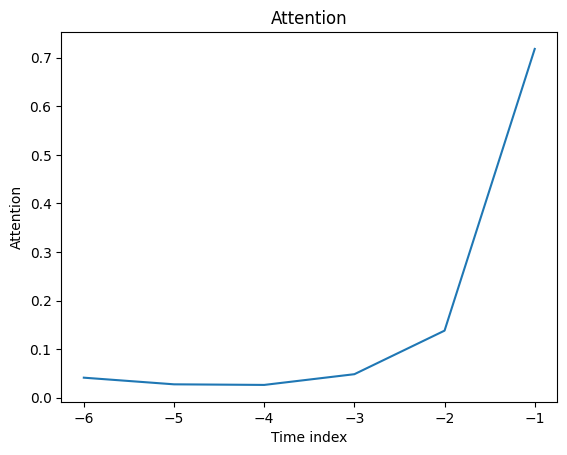

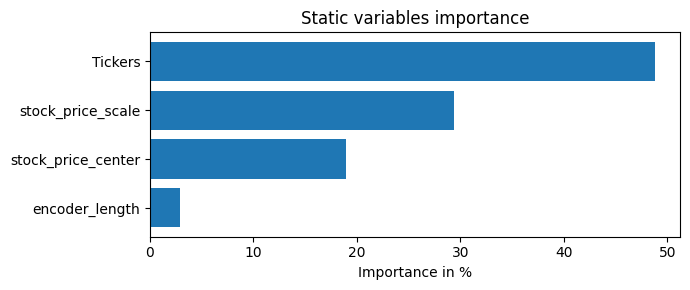

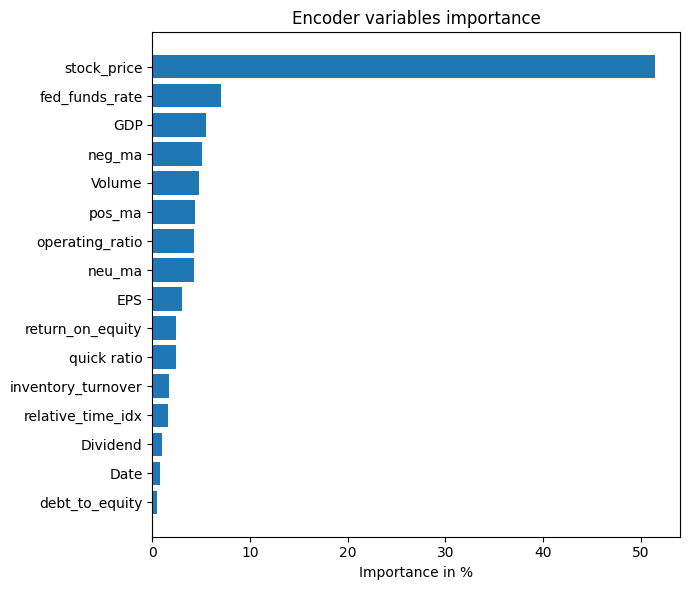

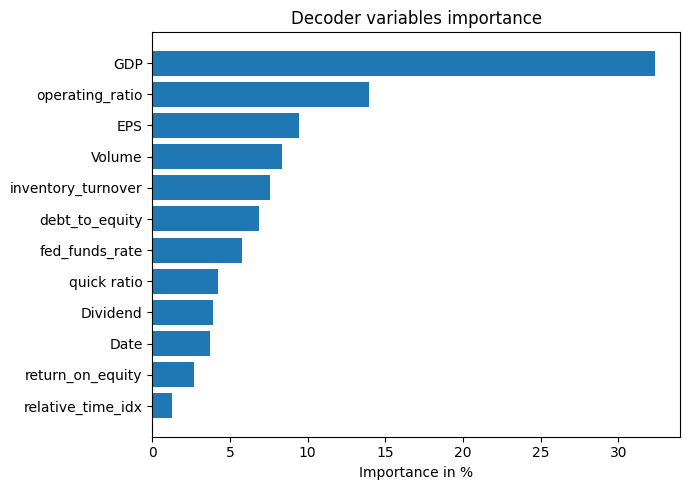

In [106]:
# Feature prioritization
interpretation = best_tft.interpret_output(raw_predictions.output, reduction='sum')
best_tft.plot_interpretation(interpretation)

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'stock_price_center': <Figure size 1000x500 with 2 Axes>,
 'stock_price_scale': <Figure size 1000x500 with 2 Axes>,
 'Date': <Figure size 1000x500 with 2 Axes>,
 'Dividend': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'fed_funds_rate': <Figure size 1000x500 with 2 Axes>,
 'GDP': <Figure size 1000x500 with 2 Axes>,
 'debt_to_equity': <Figure size 1000x500 with 2 Axes>,
 'EPS': <Figure size 1000x500 with 2 Axes>,
 'return_on_equity': <Figure size 1000x500 with 2 Axes>,
 'quick ratio': <Figure size 1000x500 with 2 Axes>,
 'operating_ratio': <Figure size 1000x500 with 2 Axes>,
 'inventory_turnover': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'stock_price': <Figure size 1000x500 with 2 Axes>,
 'pos_ma': <Figure size 1000x500 with 2 Axes>,
 'neu_ma': <Figure size 1000x500 with 2 Axes>,
 'neg_ma': <Figure size 1000x500 with 2 Axes>,
 'Tickers': <F

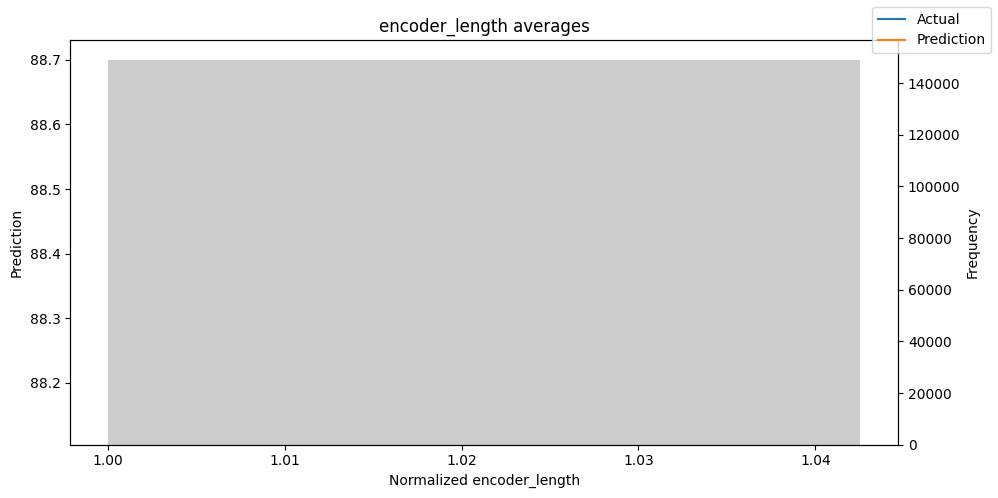

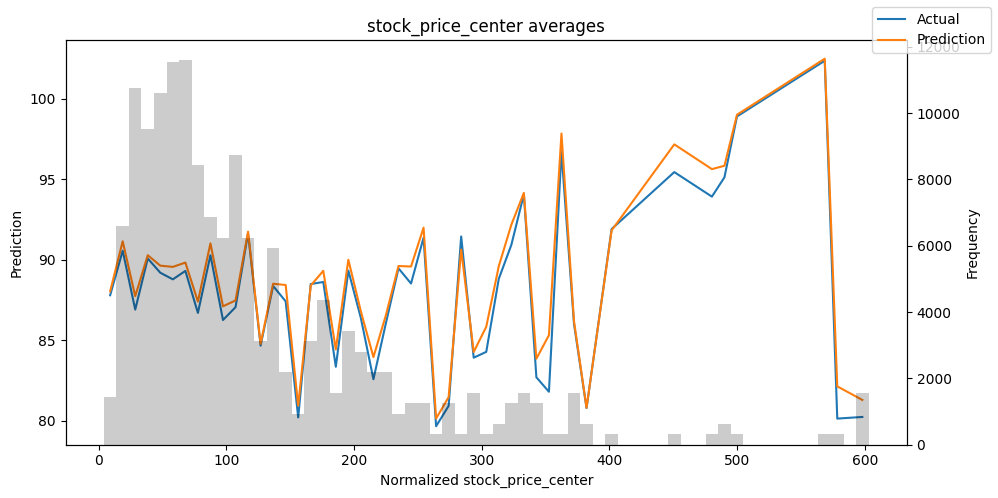

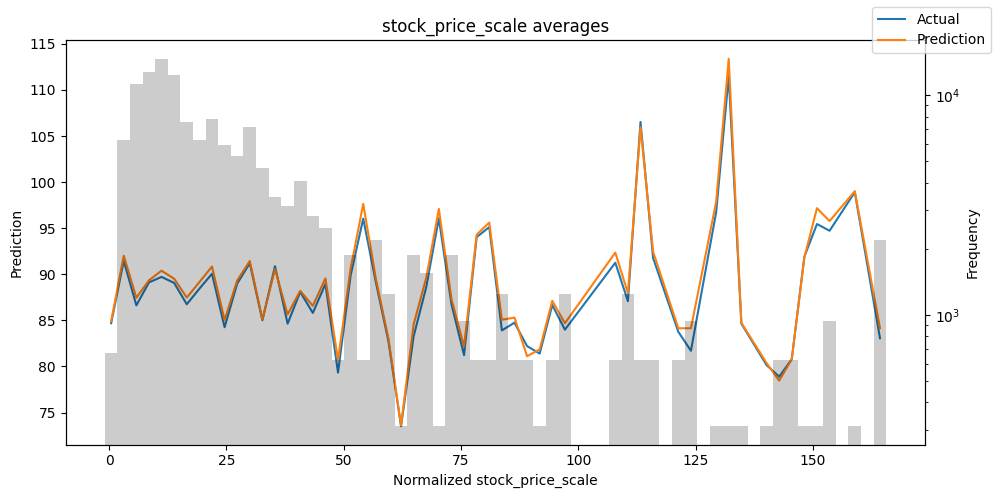

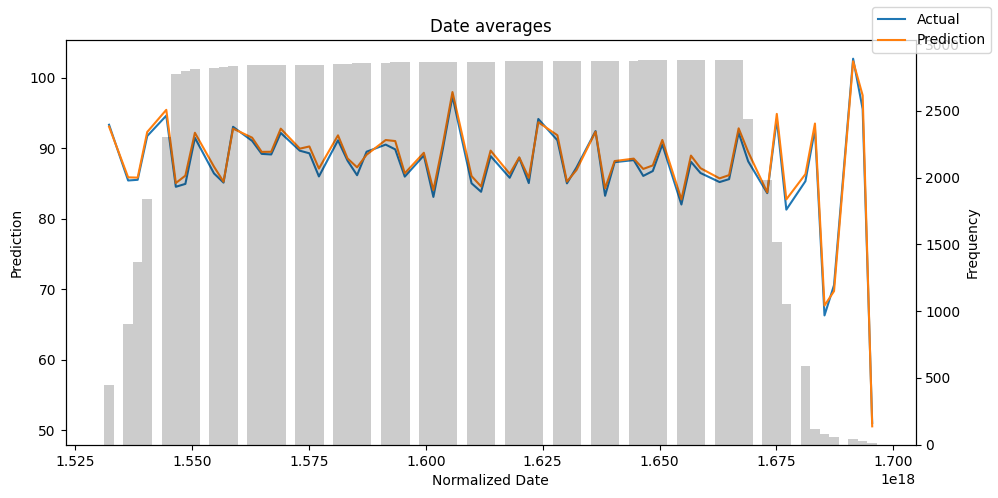

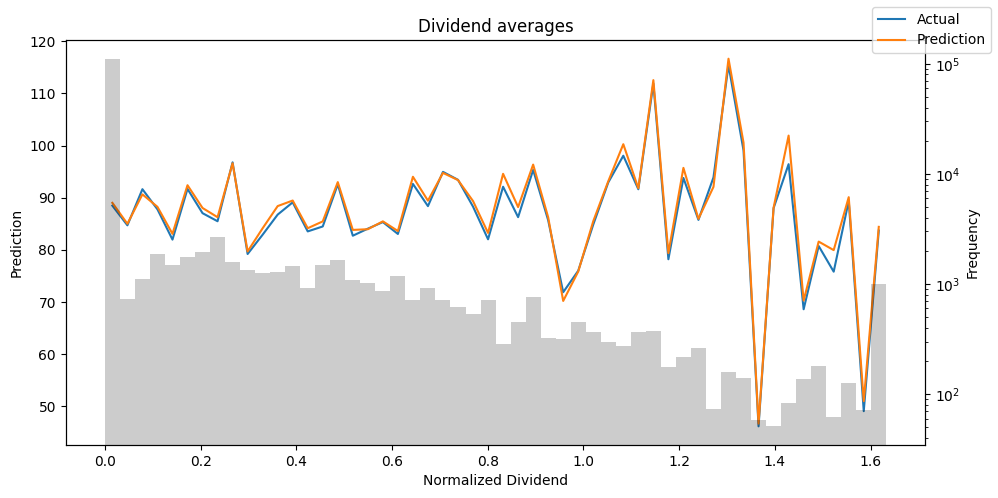

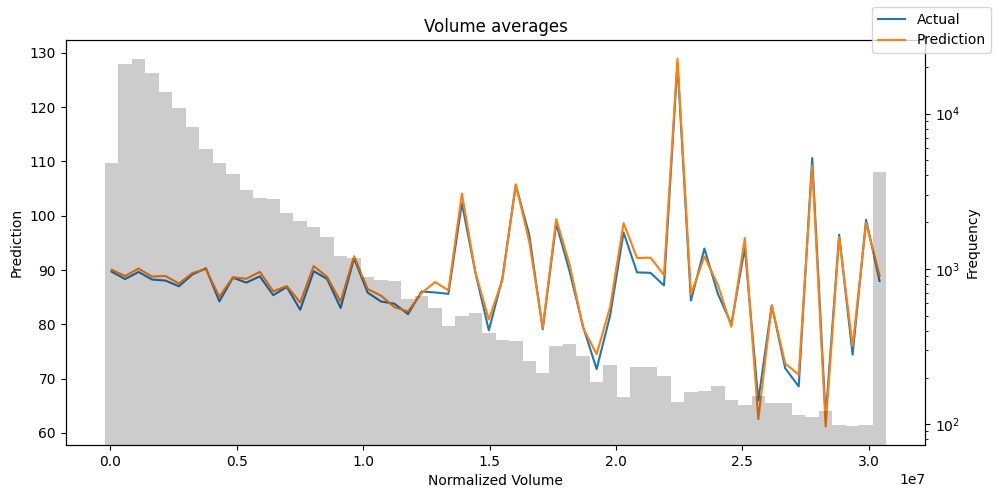

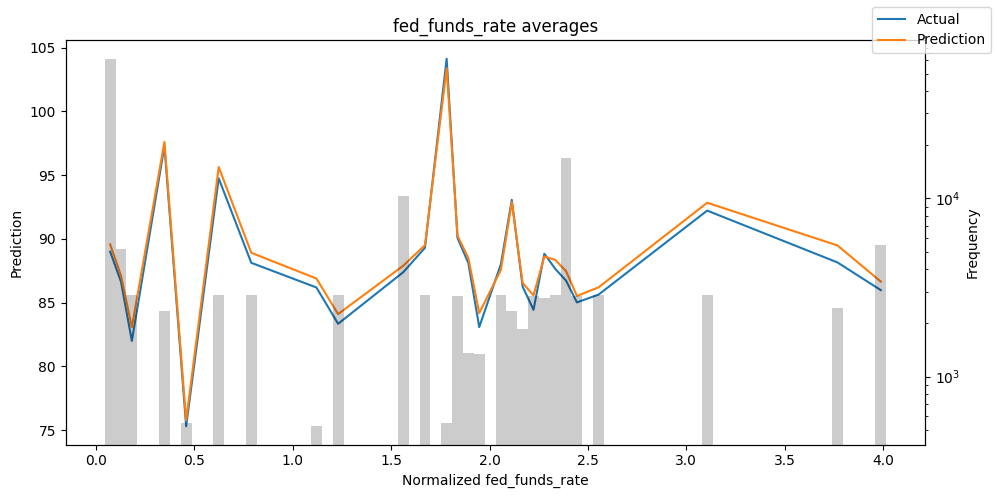

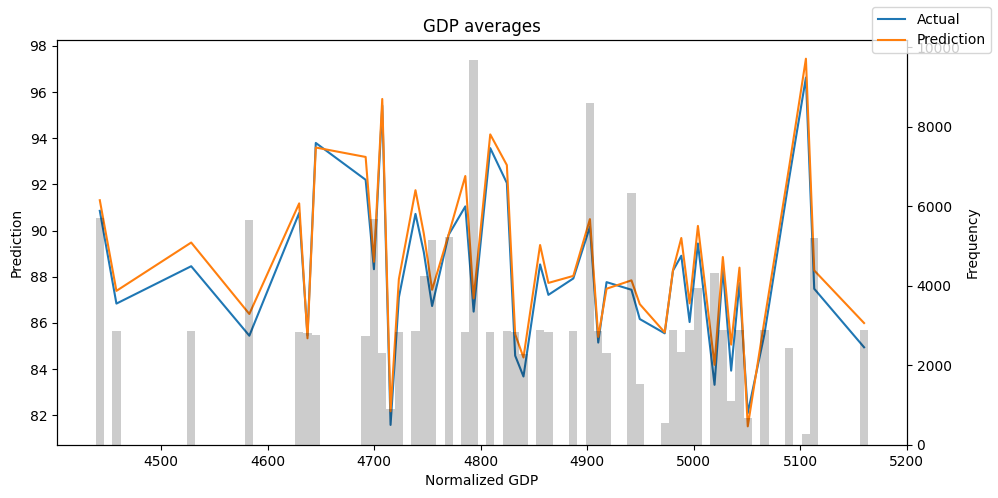

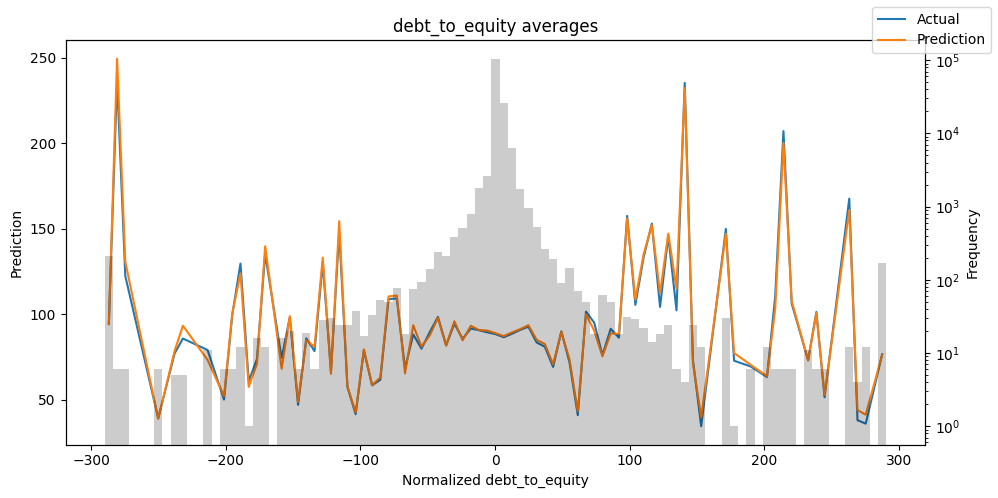

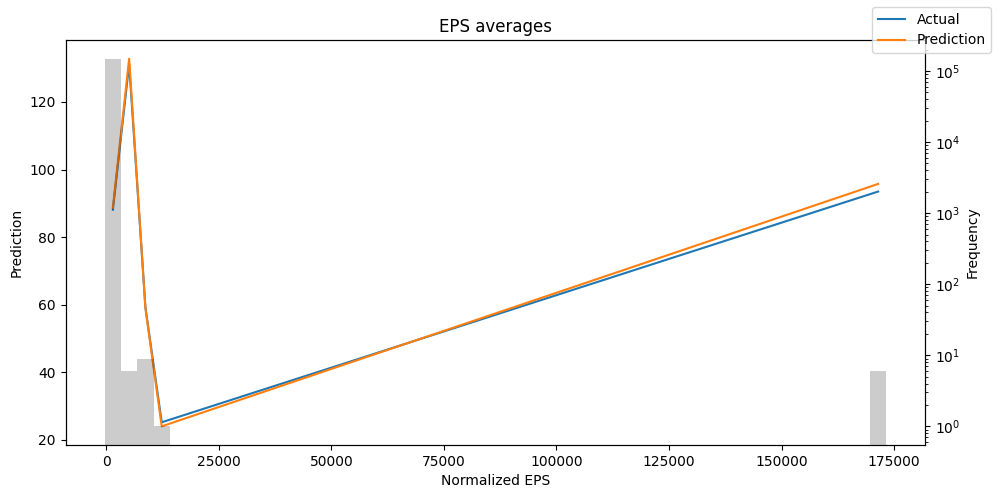

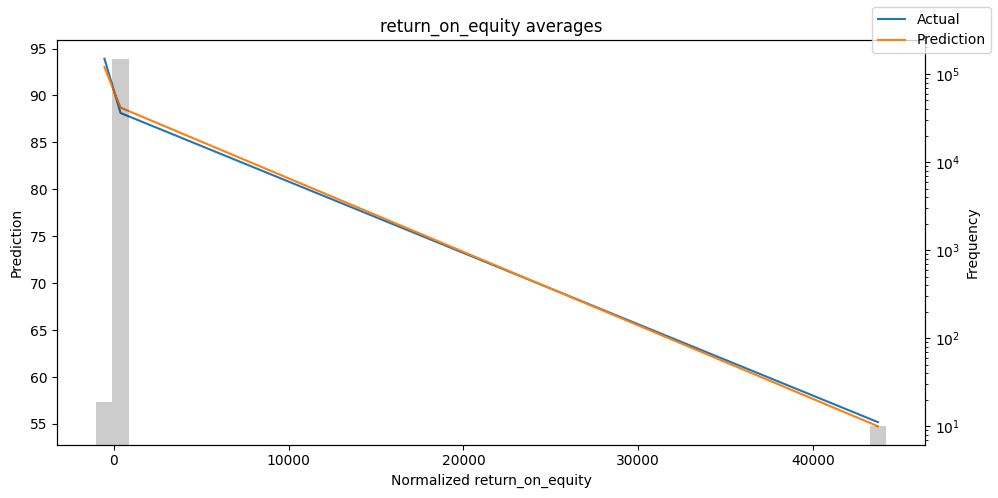

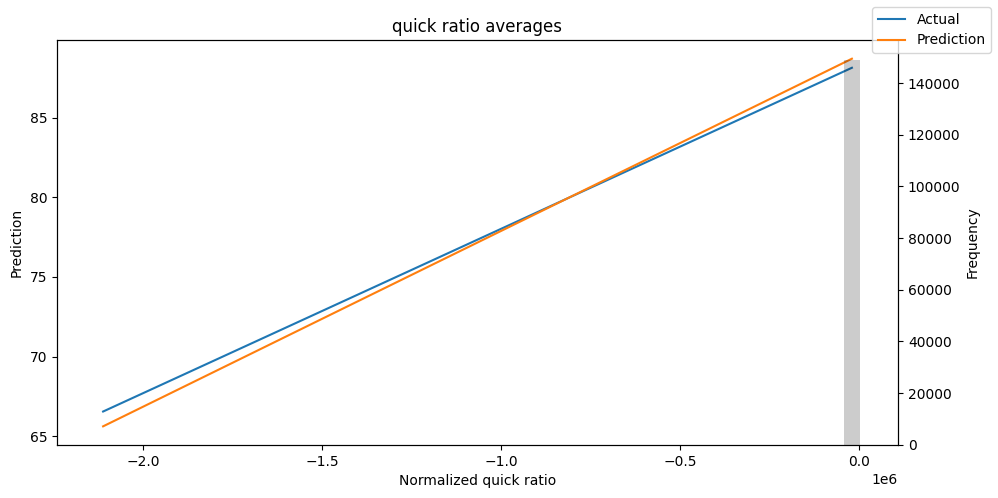

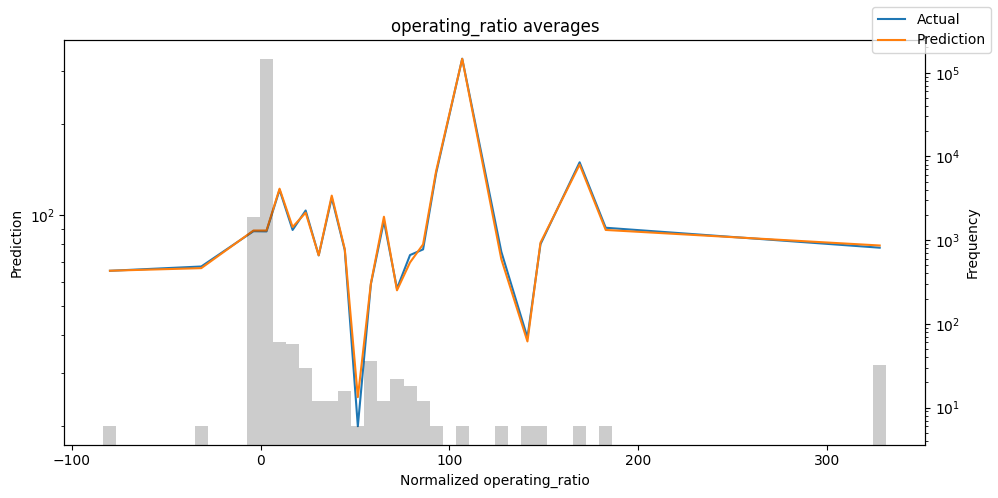

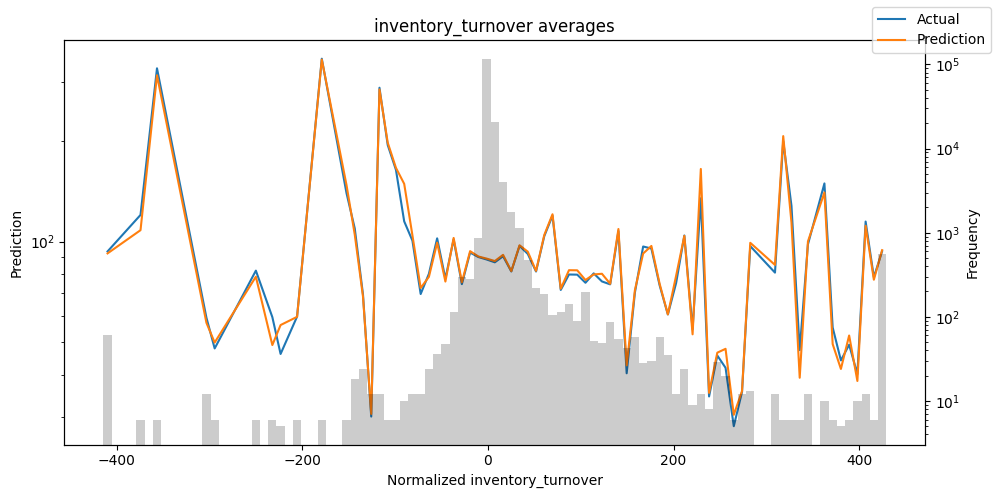

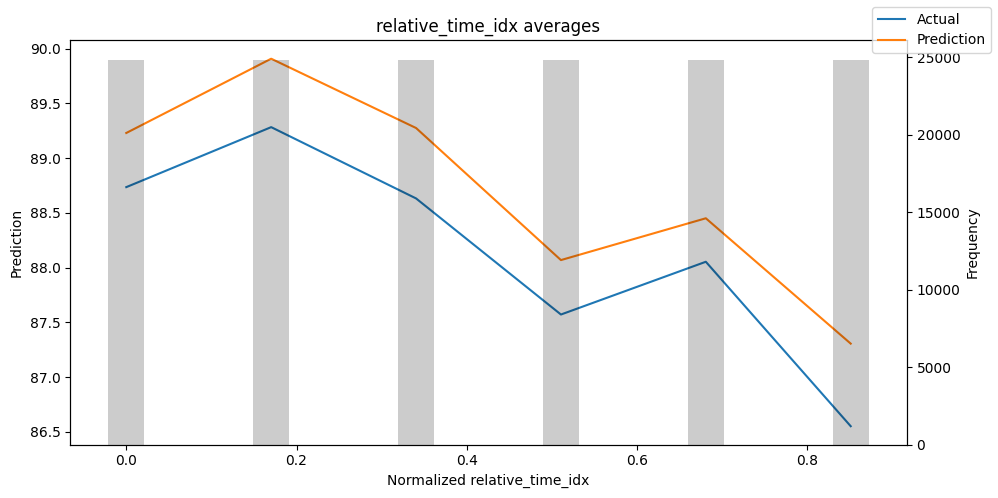

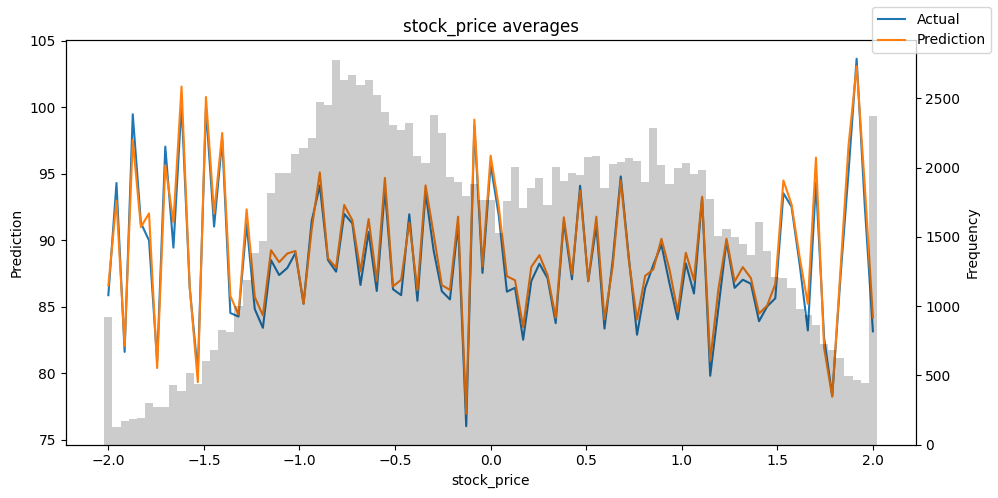

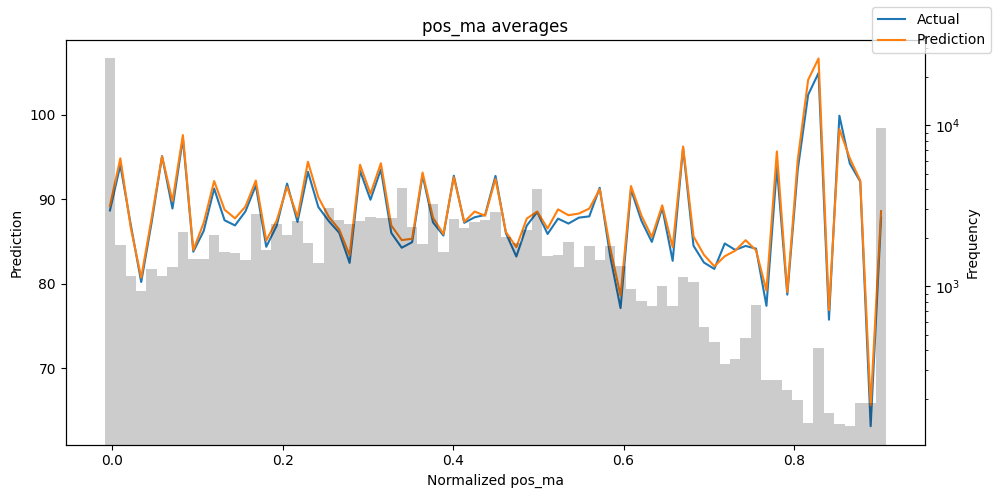

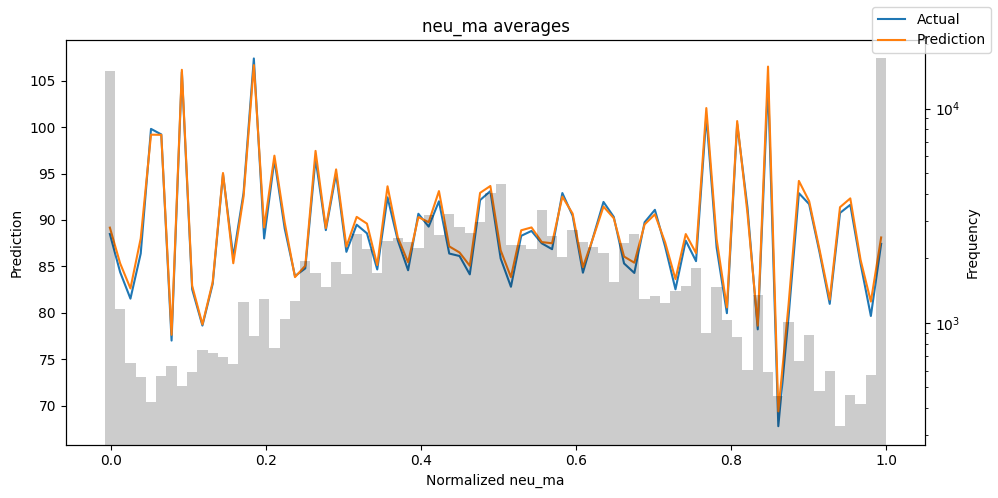

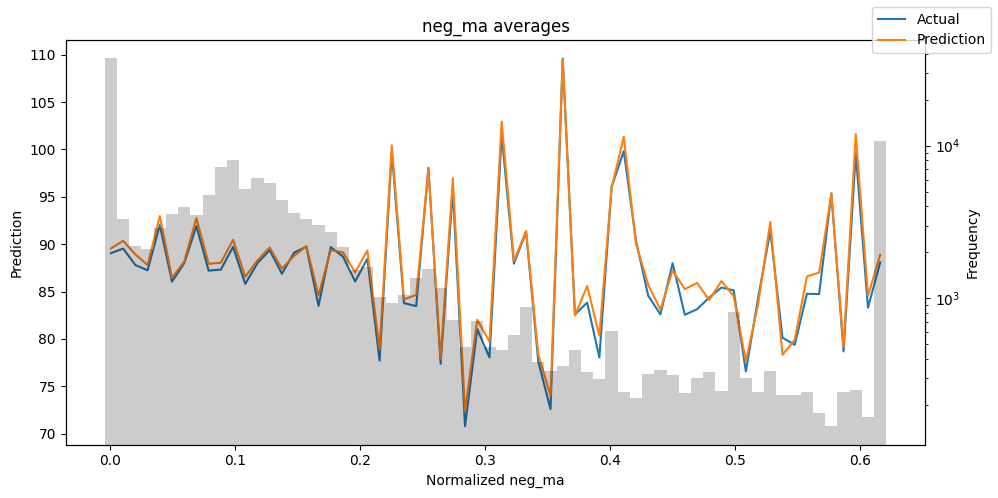

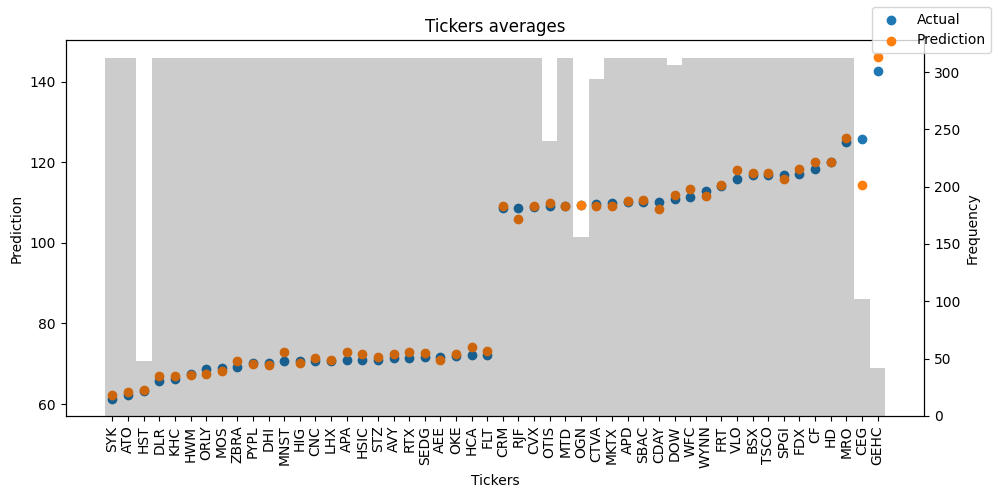

In [107]:
# Analysis on training set
predictions = best_tft.predict(train_dataloader, return_x=True, trainer_kwargs=dict(accelerator='cpu'))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

{'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'stock_price_center': <Figure size 1000x500 with 2 Axes>,
 'stock_price_scale': <Figure size 1000x500 with 2 Axes>,
 'Date': <Figure size 1000x500 with 2 Axes>,
 'Dividend': <Figure size 1000x500 with 2 Axes>,
 'Volume': <Figure size 1000x500 with 2 Axes>,
 'fed_funds_rate': <Figure size 1000x500 with 2 Axes>,
 'GDP': <Figure size 1000x500 with 2 Axes>,
 'debt_to_equity': <Figure size 1000x500 with 2 Axes>,
 'EPS': <Figure size 1000x500 with 2 Axes>,
 'return_on_equity': <Figure size 1000x500 with 2 Axes>,
 'quick ratio': <Figure size 1000x500 with 2 Axes>,
 'operating_ratio': <Figure size 1000x500 with 2 Axes>,
 'inventory_turnover': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'stock_price': <Figure size 1000x500 with 2 Axes>,
 'pos_ma': <Figure size 1000x500 with 2 Axes>,
 'neu_ma': <Figure size 1000x500 with 2 Axes>,
 'neg_ma': <Figure size 1000x500 with 2 Axes>,
 'Tickers': <F

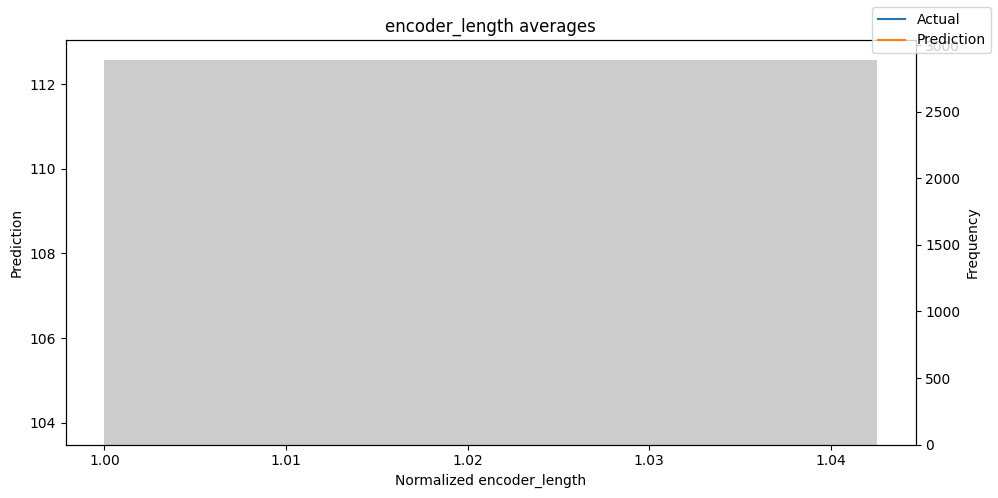

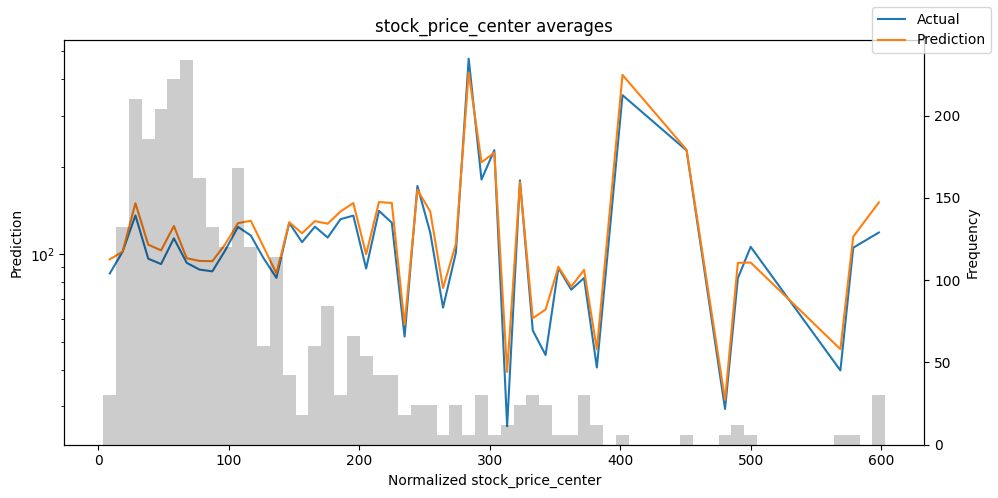

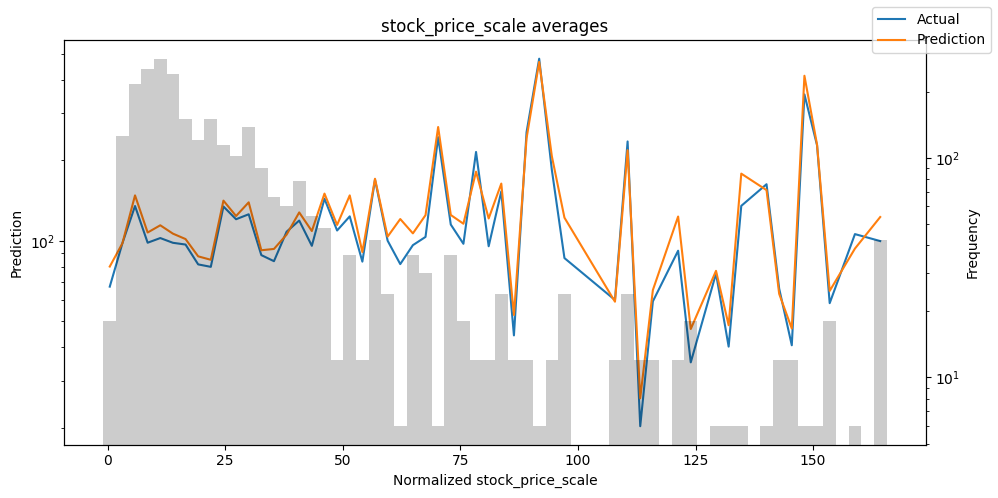

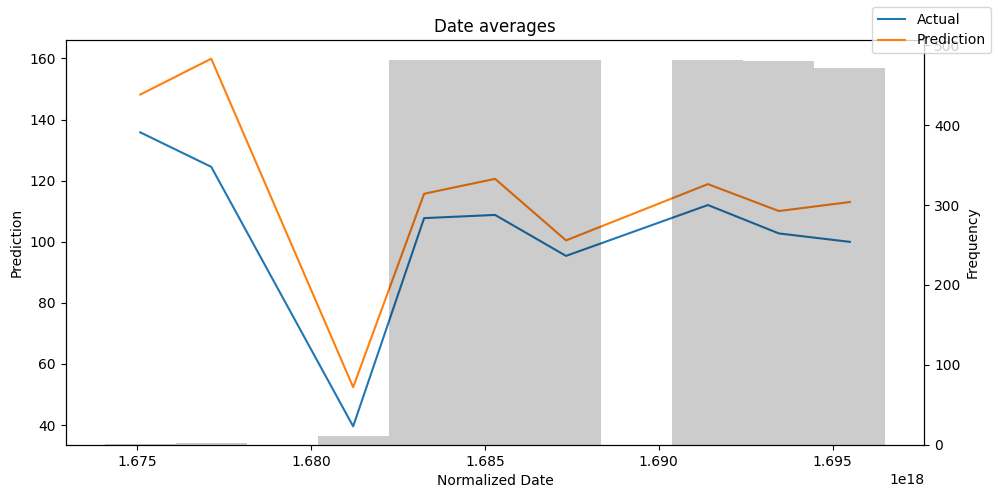

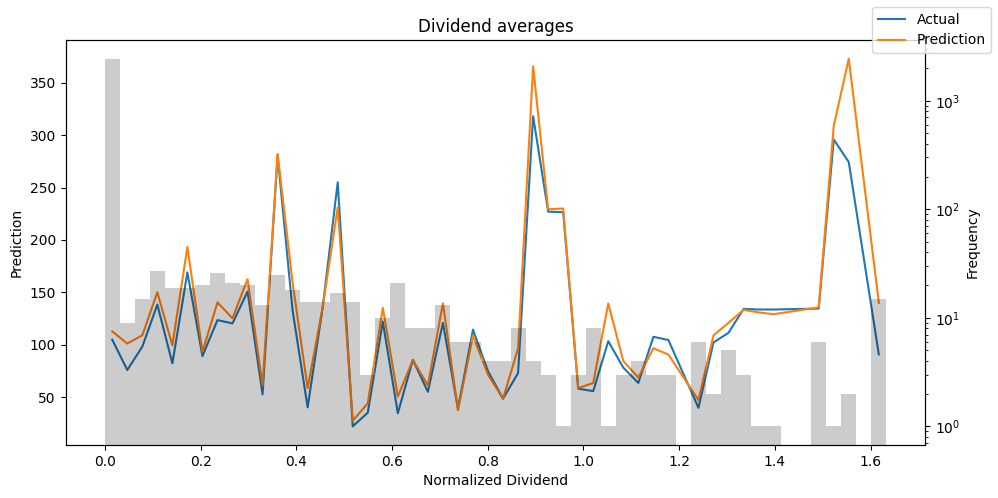

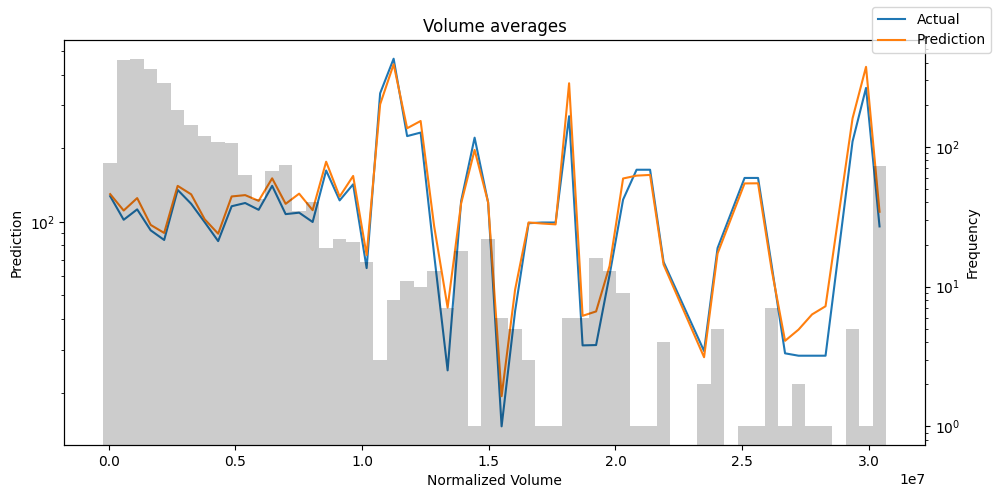

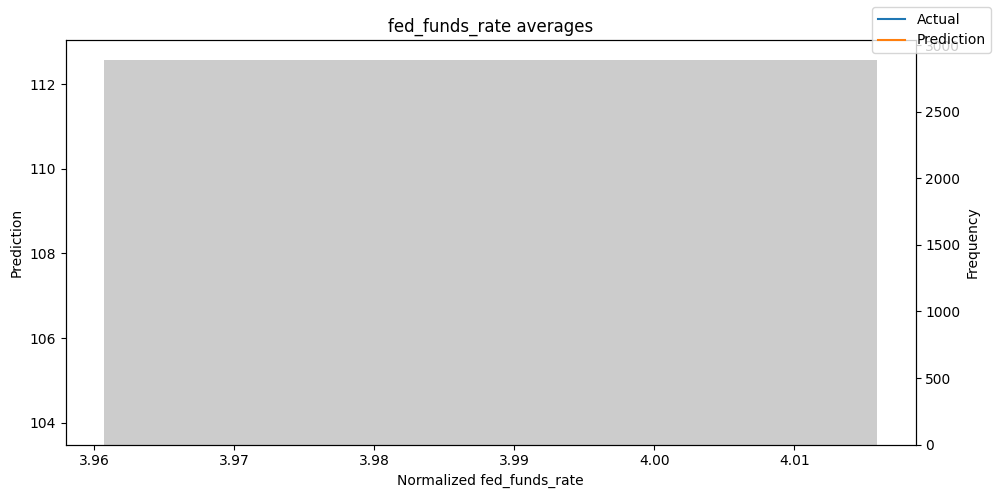

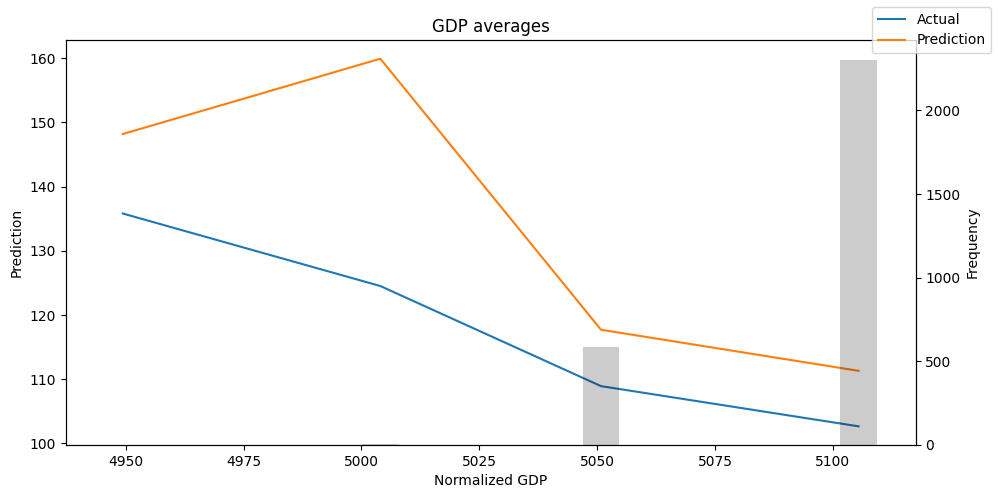

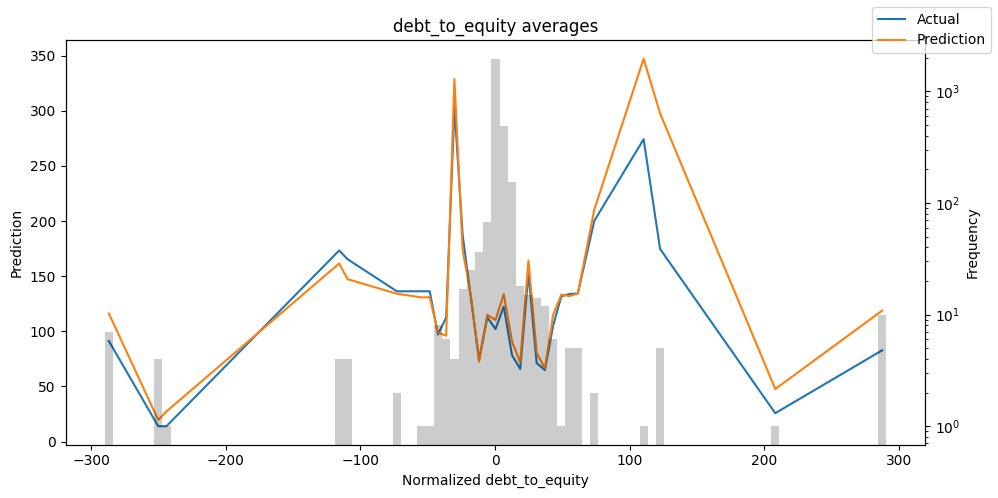

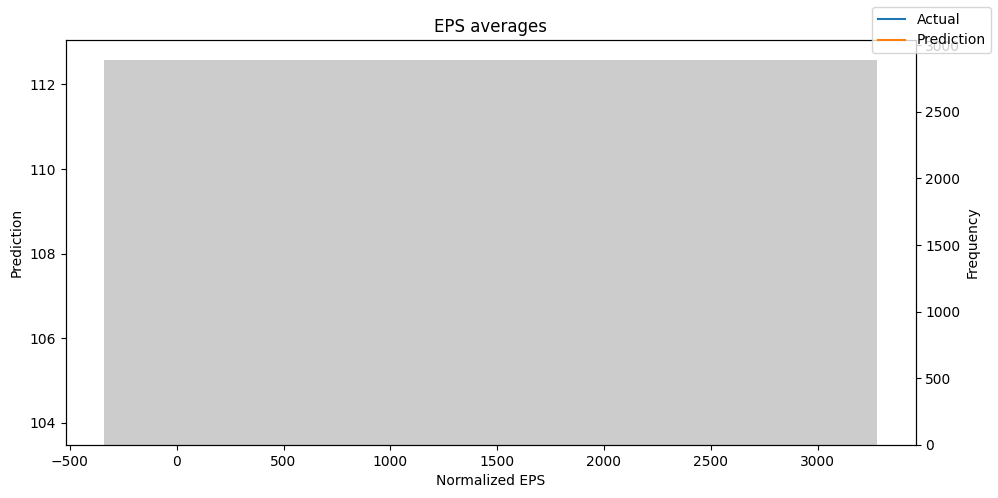

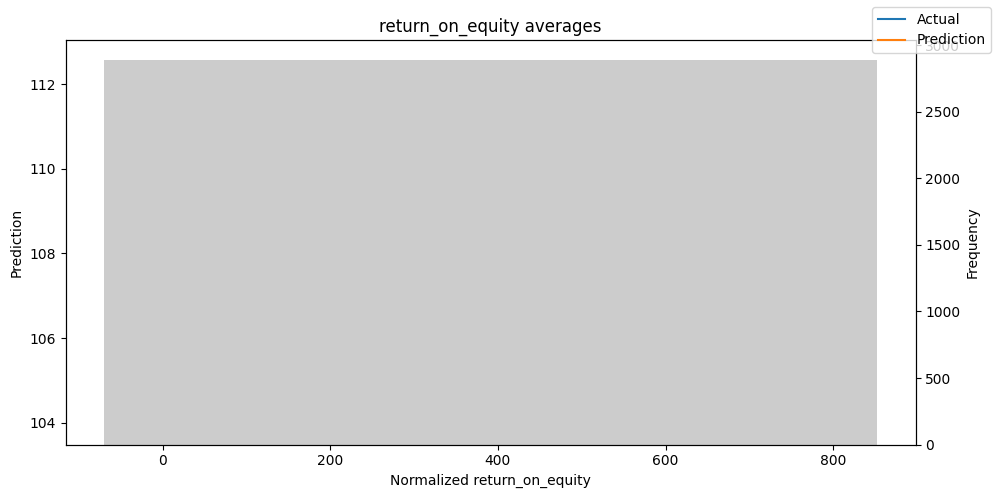

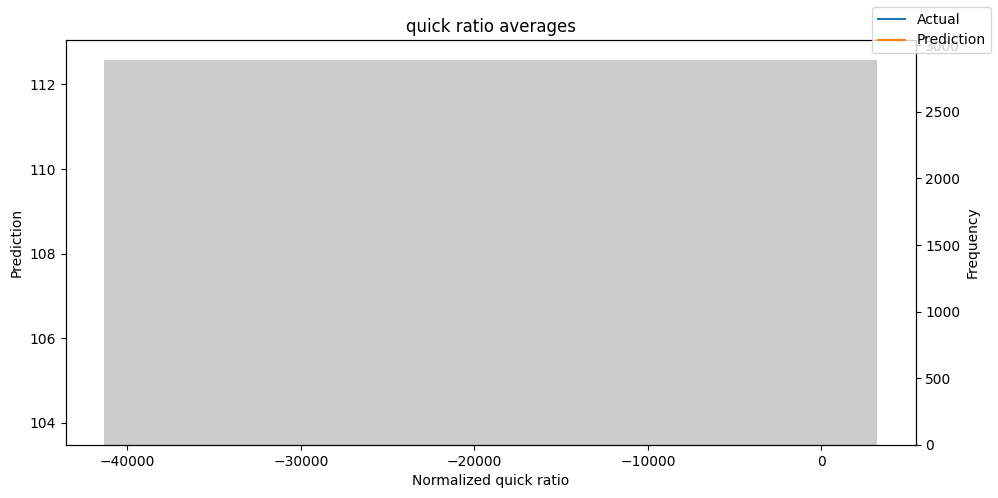

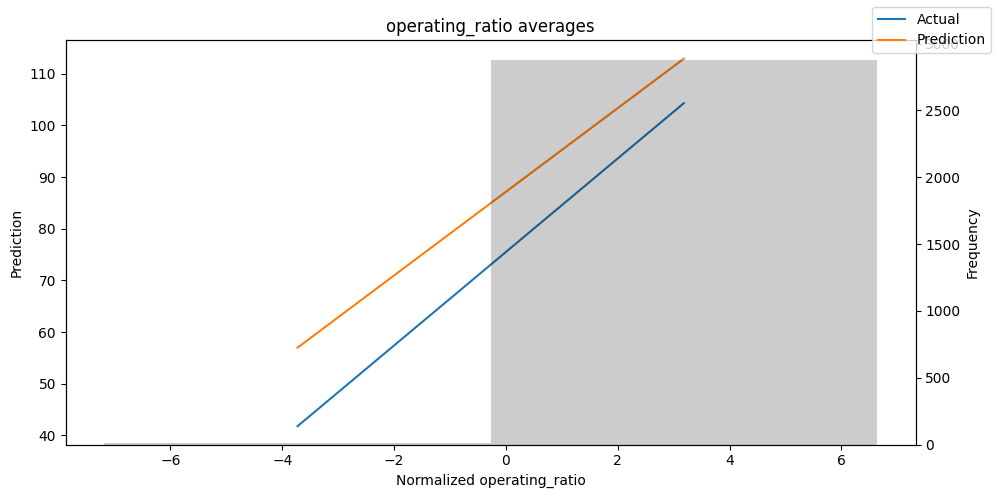

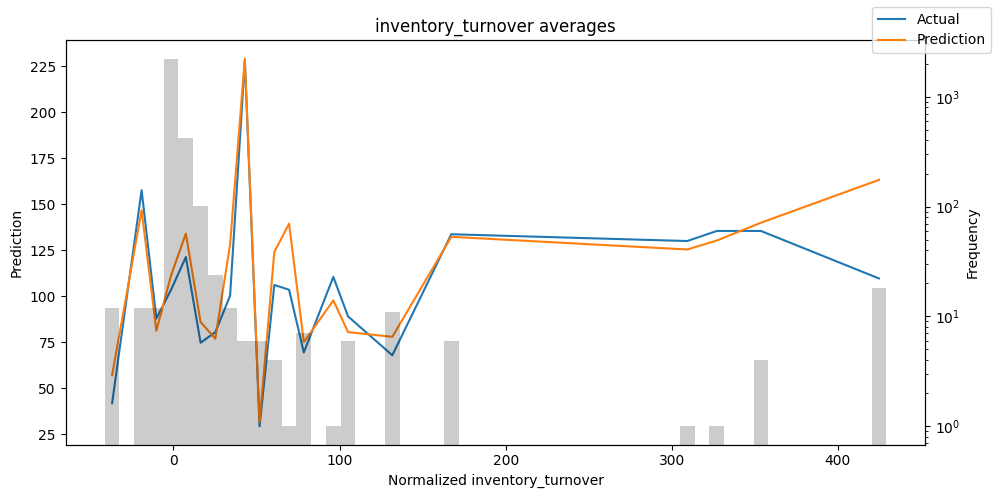

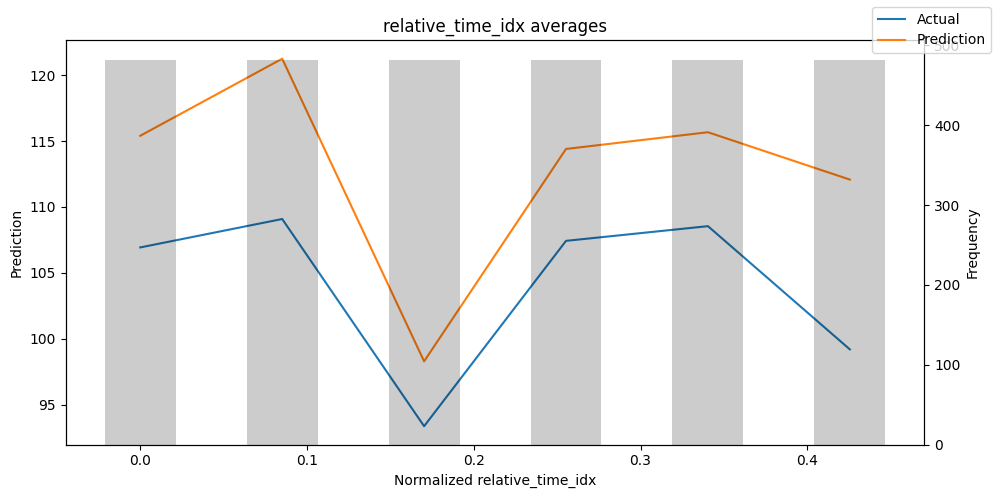

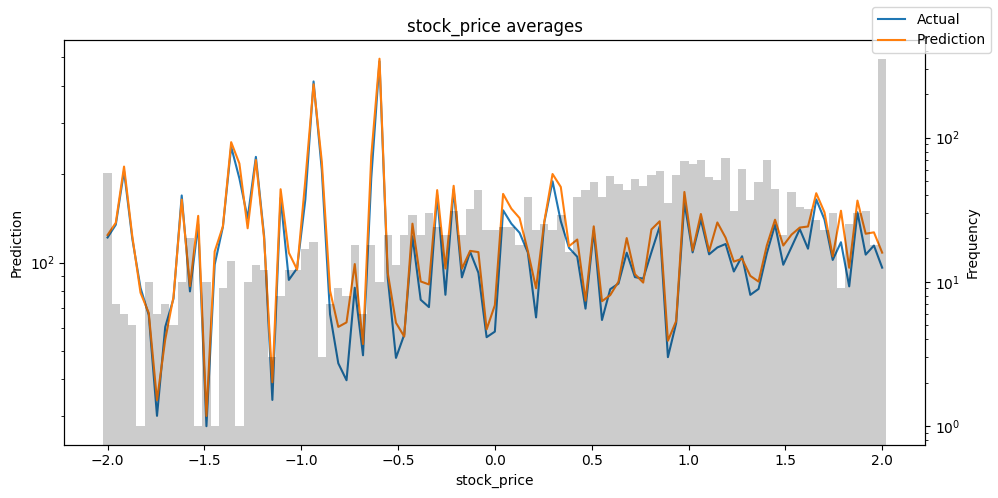

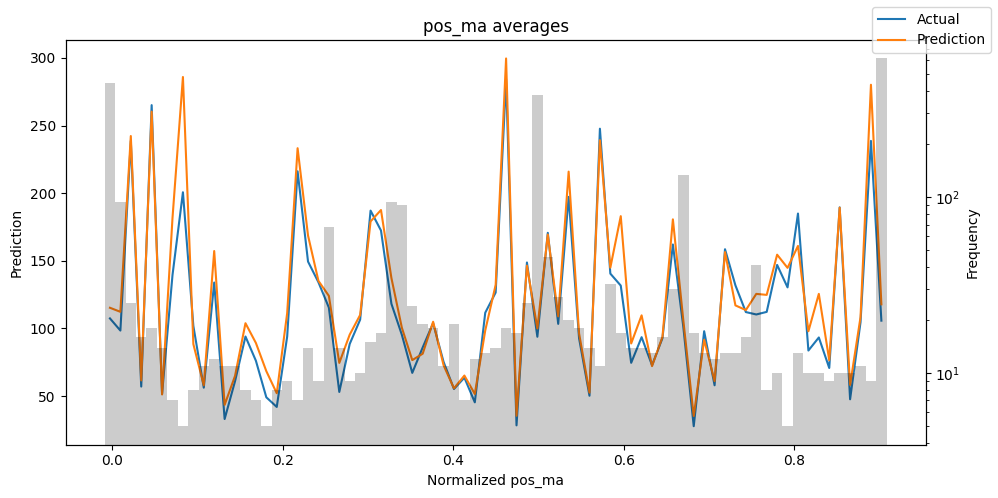

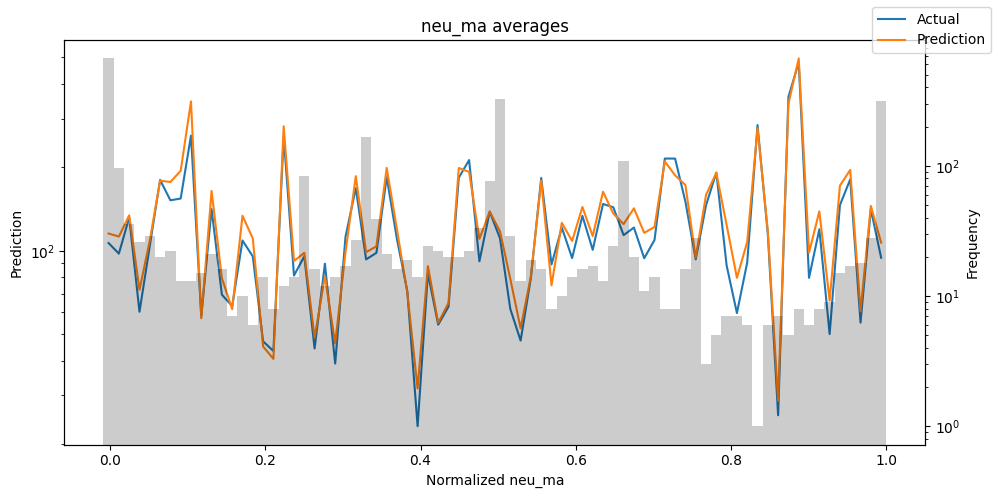

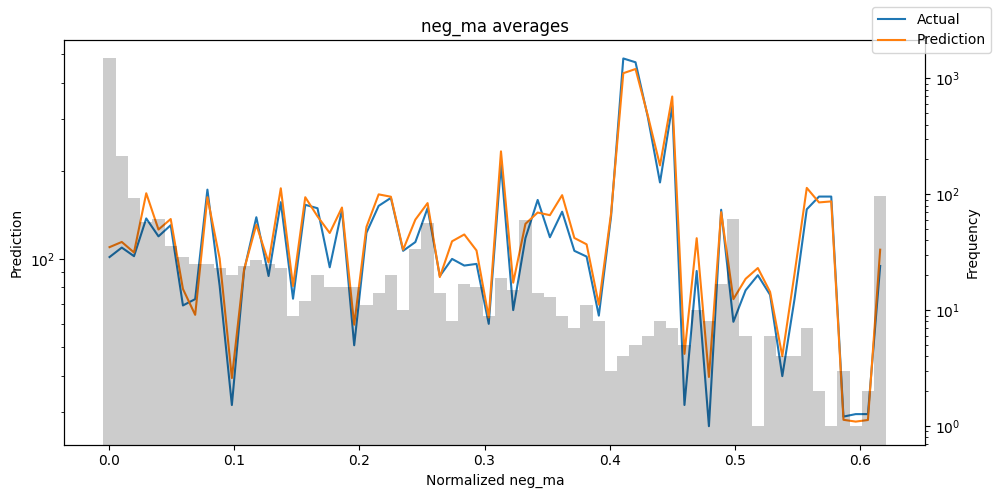

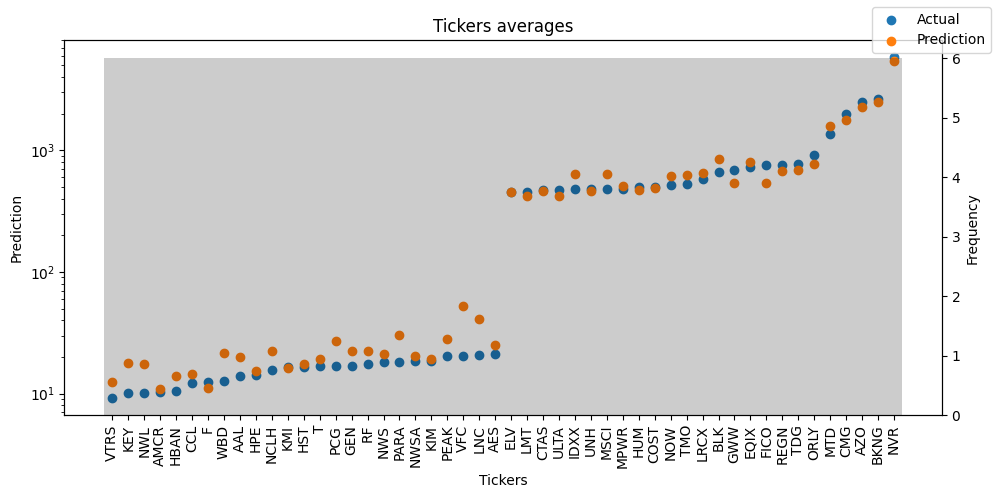

In [283]:
# Analysis on training set
predictions = best_tft.predict(val_dataloader, return_x=True, trainer_kwargs=dict(accelerator='cpu'))
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(predictions.x, predictions.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

In [1]:
import pandas as pd

start_date = pd.to_datetime("2018-01-31")
target_date = pd.to_datetime("2023-08-31")  # Replace with start date input from streamlit

# Calculate no. of months between the start and target date
num_months = (target_date.year - start_date.year) * 12 + (target_date.month - start_date.month)
target_idx = num_months


In [2]:
target_idx

67

In [168]:
# select last 6 months from data (max_encoder_length is 6)
max_prediction_length = 12

encoder_data = df_pytorch[lambda x: (x.Tickers == "TSLA") & (x.Index > x.Index.max() - 12)]

# select last known data point and create decoder data from it by repeating it and incrementing the month
last_data = df_pytorch[lambda x: (x.Tickers == "TSLA") & (x.Index == x.Index.max())]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.Date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["Index"] = decoder_data["Date"].dt.year * 12 + decoder_data["Date"].dt.month
decoder_data["Index"] += encoder_data["Index"].max() + 1 - decoder_data["Index"].min()

# adjust additional time feature(s)
# decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

In [169]:
new_raw_predictions = best_tft.predict(encoder_data,
                                       mode="raw",
                                       return_x=True,
                                       trainer_kwargs=dict(accelerator='cpu'))

/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/huiye/.pyenv/versions/3.10.6/envs/investoinsight/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


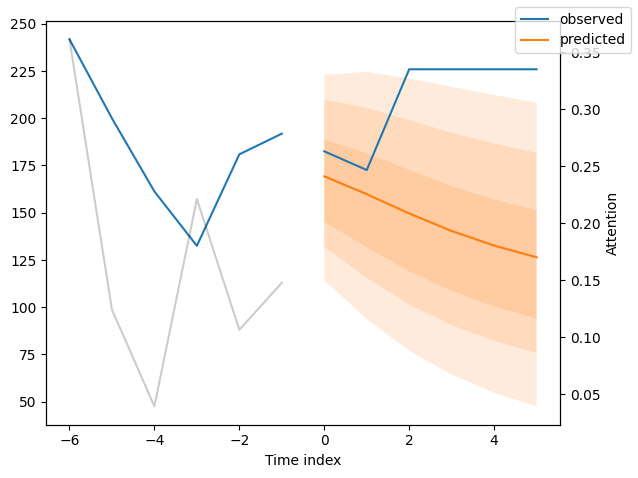

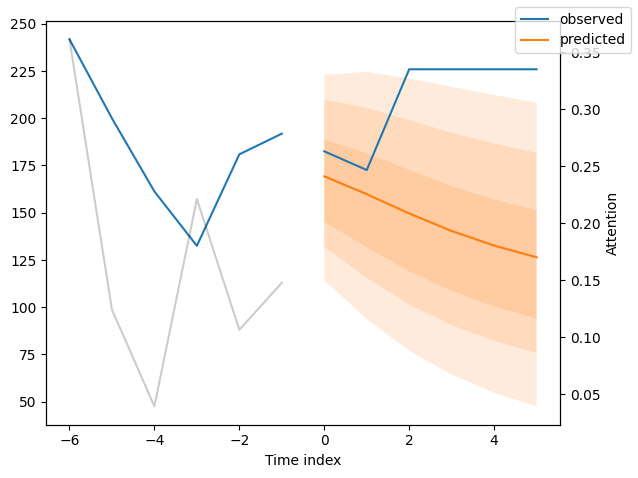

In [170]:
best_tft.plot_prediction(new_raw_predictions.x, new_raw_predictions.output,
                             idx=0, show_future_observed=True)

In [171]:
new_raw_predictions.output[0]

tensor([[[114.2690, 131.8567, 145.1789, 169.2523, 188.7047, 209.7763, 222.8996],
         [ 93.7219, 115.5266, 131.8031, 159.8271, 181.5498, 205.4137, 224.4668],
         [ 77.0256, 101.3704, 118.9956, 149.6169, 172.6297, 198.9777, 221.1105],
         [ 64.3789,  90.5205, 108.6493, 140.3296, 164.0559, 192.3141, 216.6203],
         [ 54.7247,  82.1301, 100.3834, 132.6140, 156.9561, 186.5859, 212.3035],
         [ 47.5261,  75.7167,  93.9093, 126.4126, 151.2838, 181.7154, 208.2964]]])

In [177]:
tensor = new_raw_predictions.output[0]
max_values, _ = torch.max(tensor, dim=2)
row_means = torch.mean(tensor_data, dim=2)

tensor([[222.8996, 224.4668, 221.1105, 216.6203, 212.3035, 208.2964]])

In [178]:
value1, value2, value3, value4, value5, value6 = row_means[0]
print(value1)
print(value2)
print(value3)
print(value4)
print(value5)
print(value6)

tensor(168.8482)
tensor(158.9013)
tensor(148.5323)
tensor(139.5527)
tensor(132.2425)
tensor(126.4086)


In [179]:
values_as_float = max_values[0].tolist()
values_as_float

[222.89955139160156,
 224.46681213378906,
 221.11050415039062,
 216.62034606933594,
 212.303466796875,
 208.29637145996094]

In [180]:
# Assign each value to separate variables
var1, var2, var3, var4, var5, var6 = values_as_float

print(var1)
print(var2)
print(var3)
print(var4)
print(var5)
print(var6)

222.89955139160156
224.46681213378906
221.11050415039062
216.62034606933594
212.303466796875
208.29637145996094


## N-HiTS

In [227]:
!pip install cpflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for backports.functools-lru-cache>=1.6.1 from https://files.pythonhosted.org/packages/08/e3/1387bd1c9aa95e354064ee29b8a1dfd3e795b066cc869af8f8d6b70ae4aa/backports.functools_lru_cache-1.6.6-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 3.4 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.4/97.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Obtaining dependency information for h5py from https://files.pythonhosted.org/packages/4

In [228]:
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, NHiTS, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, RMSE, MQF2DistributionLoss, QuantileLoss

from cpflows.flows import ActNorm
from cpflows.icnn import PICNN

In [265]:
# create dataset and dataloaders
max_encoder_length = 6
max_prediction_length = 6

training_cutoff = df_pytorch["time_idx"].max() - max_prediction_length * 2

context_length = max_encoder_length
prediction_length = max_prediction_length

n_training = TimeSeriesDataSet(
    df_pytorch[lambda x:x.time_idx <= training_cutoff], 
    group_ids=['Tickers'],
    target='stock_price',
    time_idx='time_idx',
    max_encoder_length=6,
    max_prediction_length=12,
    static_categoricals=['Tickers'],
    time_varying_known_reals=["Date", "Dividend", 'Volume', 'fed_funds_rate', 'GDP',
                               'debt_to_equity', 'EPS', 'return_on_equity', 'quick ratio',
                               'operating_ratio', 'inventory_turnover'],
    # time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["stock_price", 'pos_ma','neu_ma', 'neg_ma'],
    target_normalizer=GroupNormalizer(
        groups=['Tickers'], transformation="softplus"
    ),
    add_relative_time_idx=False)

n_validation = TimeSeriesDataSet.from_dataset(n_training, df_pytorch, min_prediction_idx=training_cutoff + 1)
batch_size = 128
n_train_dataloader = n_training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
n_val_dataloader = n_validation.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

In [266]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

tensor(0.1263)

In [267]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

tensor(76.0460)

In [268]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(baseline_predictions.output, baseline_predictions.y)

tensor(22.7062)

In [269]:
pl.seed_everything(43)
trainer = pl.Trainer(
    accelerator='cpu',
    gradient_clip_val=0.1)

net = NHiTS.from_dataset(
    n_training,
    learning_rate=3e-2,
    weight_decay=1e-2,
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW")

In [ ]:
# find optimal learning rate
res = Tuner(trainer).lr_find(
    net, 
    train_dataloaders=n_train_dataloader,
    val_dataloaders=n_val_dataloader,
    min_lr=1e-3)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [ ]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=5,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=1.0,
    callbacks=[early_stop_callback],
    limit_train_batches=30,
    enable_checkpointing=True,
)


net = NHiTS.from_dataset(
    n_training,
    learning_rate=5e-3,
    log_interval=10,
    log_val_interval=1,
    weight_decay=1e-2,
    backcast_loss_ratio=0.0,
    hidden_size=64,
    optimizer="AdamW",
    loss=MQF2DistributionLoss(prediction_length=max_prediction_length),
)

trainer.fit(
    net,
    train_dataloaders=n_train_dataloader,
    val_dataloaders=n_val_dataloader,
)

**------------------------------------------------------------------------**

In [42]:
train_idx = round((len(df) * 0.80))
train_idx

26331

In [43]:
train = df.iloc[:train_idx]
test = df.iloc[train_idx:]

In [44]:
# Count rows for each Ticker in training set
ticker_counts = train.groupby('Tickers').size().reset_index(name='Row_Count')
ticker_counts.Row_Count.unique()

array([55, 56, 51, 54, 38, 15, 47, 49, 53,  4,  5, 50, 23, 37, 28])

In [45]:
symbol_row_counts = train['Tickers'].value_counts()

# Filter symbols with row counts greater than or equal to 6
symbols_to_keep = symbol_row_counts[symbol_row_counts >= 6].index.tolist()

# Filter the 'train' DataFrame to keep only the symbols with row counts >= 6
filtered_train = train[train['Tickers'].isin(symbols_to_keep)]

filtered_train.shape

(26322, 17)

**Note: to check tickers in training set, remove from test set**

In [18]:
# Split training set into train and validation
filtered_train_idx = round((len(filtered_train)*0.75))
filtered_train_idx

19742

In [20]:
train = filtered_train.iloc[:filtered_train_idx]
val = filtered_train.iloc[filtered_train_idx:]

In [ ]:
# Normalize time series 
scaler = MinMaxScaler(feature_range=(0, 1), copy=True, clip=False)
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
test_scaled = scaler.transform(test)

In [54]:
# convert Date column into DateTime and set as integer index in chronological order
df1 = df.copy()
df1['Date'] = pd.to_datetime(df1['Date'])

In [57]:
df1['Index'] = df1.groupby('Tickers').cumcount()
df1

Date  Dividend        Volume  stock_price  fed_funds_rate  \
0     2018-01-31      0.00  5.315047e+06    51.919825            1.41   
1     2018-01-31      0.00  1.795523e+08    40.275178            1.41   
2     2018-01-31      0.71  7.794467e+06    87.747239            1.41   
3     2018-01-31      0.28  7.860137e+06    54.655791            1.41   
4     2018-01-31      0.00  1.614810e+06    29.889667            1.41   
...          ...       ...           ...          ...             ...   
32909 2023-09-30      0.00  2.114983e+06   133.590376            5.08   
32910 2023-09-30      0.00  1.614090e+06   135.349948            5.08   
32911 2023-09-30      0.00  3.709700e+05   274.414666            5.08   
32912 2023-09-30      0.00  5.042810e+06    28.125514            5.08   
32913 2023-09-30      0.00  2.192707e+06   168.943788            5.12   

               GDP Tickers  debt_to_equity       EPS  return_on_equity  \
0      4500.182000     AAL     -134.253165  0.807713         -0.941772   
1      4500.182000    AAPL        2.413301  2.970566          0.131828   
2      4500.182000    ABBV      -23.651147  1.818001         -0.940431   
3      4500.182000     ABT        1.333073  0.319962          0.018336   
4      4500.182000    ACGL        2.331811  0.564373          0.024308   
...            ...     ...             ...       ...               ...   
32909  5105.025000     YUM       -1.693220  1.487544         -0.049550   
32910  5105.025000     ZBH        0.720673  1.004794          0.016942   
32911  5053.623333    ZBRA        1.491979  2.802807          0.048128   
32912  5105.025000    ZION       15.511452  1.181283          0.033125   
32913  5105.025000     ZTS        1.973622  1.456319          0.145081   

       quick ratio  operating_ratio  inventory_turnover    pos_ma  \
0         0.484585         0.476713            1.930838  0.285655   
1         1.098802         0.743752            9.811931  0.222114   
2         1.083967         0.657965            1.027436  0.351660   
3         1.128287         0.829424            0.837345  0.323488   
4         0.679544         0.278000            0.000000  0.000003   
...            ...              ...                 ...       ...   
32909     0.721587         0.427386            0.938914  0.008204   
32910     0.945561         0.834571            0.230908  0.499998   
32911     0.502260         0.854987            0.732639  0.999969   
32912     0.458553         0.388889          -17.000000  1.000000   
32913     1.968344         0.580734            0.224732  0.000009   

             neu_ma        neg_ma  ticker_encoded  Index  
0      5.198588e-01  1.944860e-01               1      0  
1      6.974815e-01  8.040471e-02               2      0  
2      3.990092e-01  2.493303e-01               3      0  
3      5.800269e-01  9.648529e-02               4      0  
4      1.541489e-05  9.999820e-01               5      0  
...             ...           ...             ...    ...  
32909  4.912204e-01  5.005759e-01             477     68  
32910  5.000007e-01  1.404991e-06             478     68  
32911  2.603792e-05  5.176677e-06             479     68  
32912  2.596820e-07  6.590589e-08             480     68  
32913  9.999810e-01  9.611364e-06             481     68  

[32914 rows x 18 columns]

In [59]:
df2 = df1.copy()
df2.set_index('Index', inplace=True)
df2

Date  Dividend        Volume  stock_price  fed_funds_rate  \
Index                                                                   
0     2018-01-31      0.00  5.315047e+06    51.919825            1.41   
0     2018-01-31      0.00  1.795523e+08    40.275178            1.41   
0     2018-01-31      0.71  7.794467e+06    87.747239            1.41   
0     2018-01-31      0.28  7.860137e+06    54.655791            1.41   
0     2018-01-31      0.00  1.614810e+06    29.889667            1.41   
...          ...       ...           ...          ...             ...   
68    2023-09-30      0.00  2.114983e+06   133.590376            5.08   
68    2023-09-30      0.00  1.614090e+06   135.349948            5.08   
68    2023-09-30      0.00  3.709700e+05   274.414666            5.08   
68    2023-09-30      0.00  5.042810e+06    28.125514            5.08   
68    2023-09-30      0.00  2.192707e+06   168.943788            5.12   

               GDP Tickers  debt_to_equity       EPS  return_on_equity  \
Index                                                                    
0      4500.182000     AAL     -134.253165  0.807713         -0.941772   
0      4500.182000    AAPL        2.413301  2.970566          0.131828   
0      4500.182000    ABBV      -23.651147  1.818001         -0.940431   
0      4500.182000     ABT        1.333073  0.319962          0.018336   
0      4500.182000    ACGL        2.331811  0.564373          0.024308   
...            ...     ...             ...       ...               ...   
68     5105.025000     YUM       -1.693220  1.487544         -0.049550   
68     5105.025000     ZBH        0.720673  1.004794          0.016942   
68     5053.623333    ZBRA        1.491979  2.802807          0.048128   
68     5105.025000    ZION       15.511452  1.181283          0.033125   
68     5105.025000     ZTS        1.973622  1.456319          0.145081   

       quick ratio  operating_ratio  inventory_turnover    pos_ma  \
Index                                                               
0         0.484585         0.476713            1.930838  0.285655   
0         1.098802         0.743752            9.811931  0.222114   
0         1.083967         0.657965            1.027436  0.351660   
0         1.128287         0.829424            0.837345  0.323488   
0         0.679544         0.278000            0.000000  0.000003   
...            ...              ...                 ...       ...   
68        0.721587         0.427386            0.938914  0.008204   
68        0.945561         0.834571            0.230908  0.499998   
68        0.502260         0.854987            0.732639  0.999969   
68        0.458553         0.388889          -17.000000  1.000000   
68        1.968344         0.580734            0.224732  0.000009   

             neu_ma        neg_ma  ticker_encoded  
Index                                              
0      5.198588e-01  1.944860e-01               1  
0      6.974815e-01  8.040471e-02               2  
0      3.990092e-01  2.493303e-01               3  
0      5.800269e-01  9.648529e-02               4  
0      1.541489e-05  9.999820e-01               5  
...             ...           ...             ...  
68     4.912204e-01  5.005759e-01             477  
68     5.000007e-01  1.404991e-06             478  
68     2.603792e-05  5.176677e-06             479  
68     2.596820e-07  6.590589e-08             480  
68     9.999810e-01  9.611364e-06             481  

[32914 rows x 17 columns]

**Later on, when converting integer  index back to datetime**

In [ ]:
# # Convert integer index back to datetime
# integer_index = 5  # Arbitrary integer index
# corresponding_date = df[df['integer_index'] == integer_index].index[0]
# print(f"Integer Index {integer_index} corresponds to Date: {corresponding_date}")

# # Accessing data by datetime
# specific_date = pd.Timestamp('2021-05-01')  # Arbitrary date
# value_at_date = df.loc[specific_date, 'value']
# print(f"Value at {specific_date}: {value_at_date}")

In [ ]:
# create time series object for target variable
ts_P = TimeSeries.from_series(df2['stock_price'])

# check attributes of the time series
print("components:", ts_P.components)
print("duration:",ts_P.duration)
print("frequency:",ts_P.freq)
print("frequency:",ts_P.freq_str)
print("has date time index? (or else, it must have an integer index):",ts_P.has_datetime_index)
print("deterministic:",ts_P.is_deterministic)
print("univariate:",ts_P.is_univariate)